# **Interrogate latent spaces**

In this notebook, use the full BuDDI model. We will analyze the latent spaces and contrast them against each other. We show that some of the latent spaces are disentangled, but not fully. This is because some latent spaces are inherently dependent on one another (some samples are perturbed and others are not, so sample IDs and perturbation status are not independent.) We also show that the cell-type proportion estimator performs roughly as well as CIBERSORTx and BayesPrism. While our proportion estimator is not the main feature of our model, we show that our performance is competitive with commonly used (CIBERSORTx) and state-of-the-art (BayesPrism) methods. NOTE: Only CD14 monocytes are perturbed. The reference single-cell profiles are from non-perturbed CD14 monocytes and the task is to deconvolve bulk that has perturbed CD14 monocytes, but all other cell-types are unperturbed.


The data we use is the Kang data. We augment this dataset by modifying the stimulated cells. We only use stimulated monocytes in order to show the specificity in which BuDDI can work. Since the ground truth stimulation provides a global shift in expression, using only one cell type as the perturbed observation shows that BuDDI can truely identify a cell-type specific perturbation.


# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job22_Results.csv"
cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_kang/"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [5]:
# get the info for CIBERSORT
_, _, _, sig_df, _ = sc_preprocess.read_single_kang_pseudobulk_file(aug_data_path, 
                                                                         "1256", "CTRL", 
                                                                         "Train", exp_id)


# get the bulks we will use in training to compare with BuDDI
cibersort_bulk_idx = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]
cibersort_bulk_df = X_full.iloc[cibersort_bulk_idx]

# now we transpose
cibersort_bulk_df = cibersort_bulk_df.transpose()
cibersort_bulk_df.columns = range(cibersort_bulk_df.shape[1])


# now write it out
sc_preprocess.write_cs_bp_files(cibersort_path, exp_id, sig_df, cibersort_bulk_df)



# Define indices and set-up metadata

In [6]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

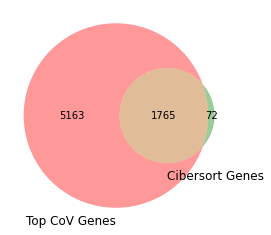

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

# Normalize data

In [9]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.101s...
[t-SNE] Computed neighbors for 17320 samples in 26.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

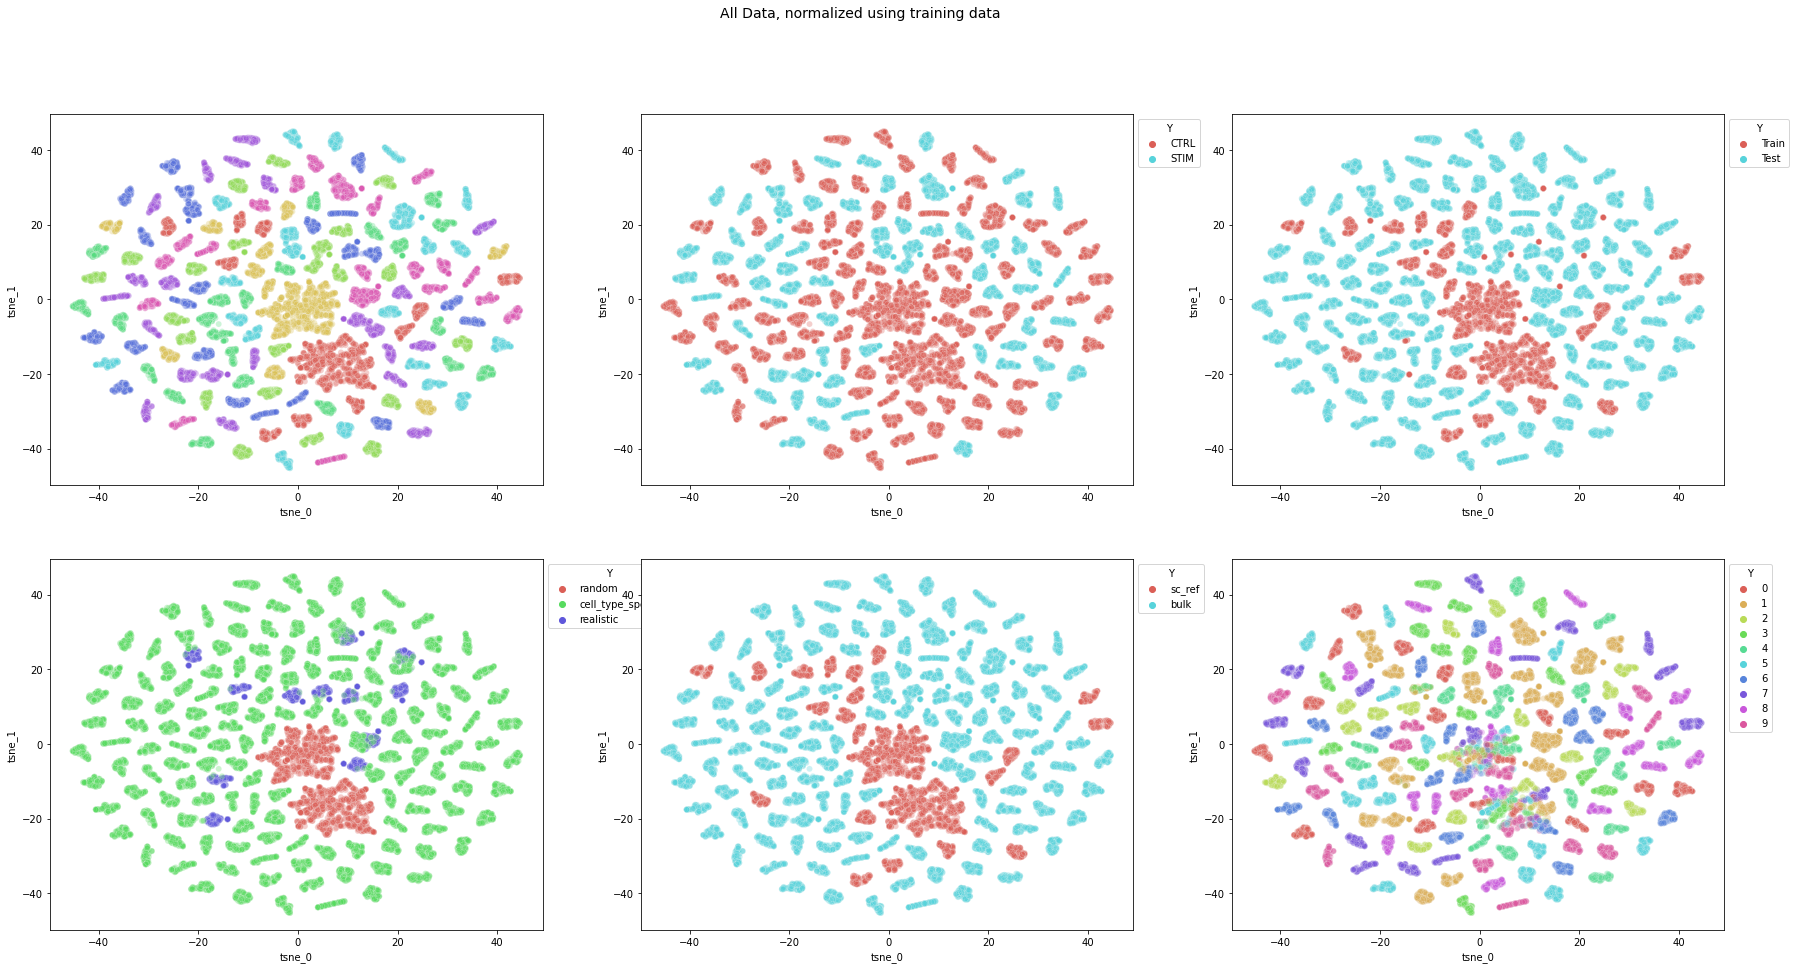

In [10]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(120, 2)
(120, 2)


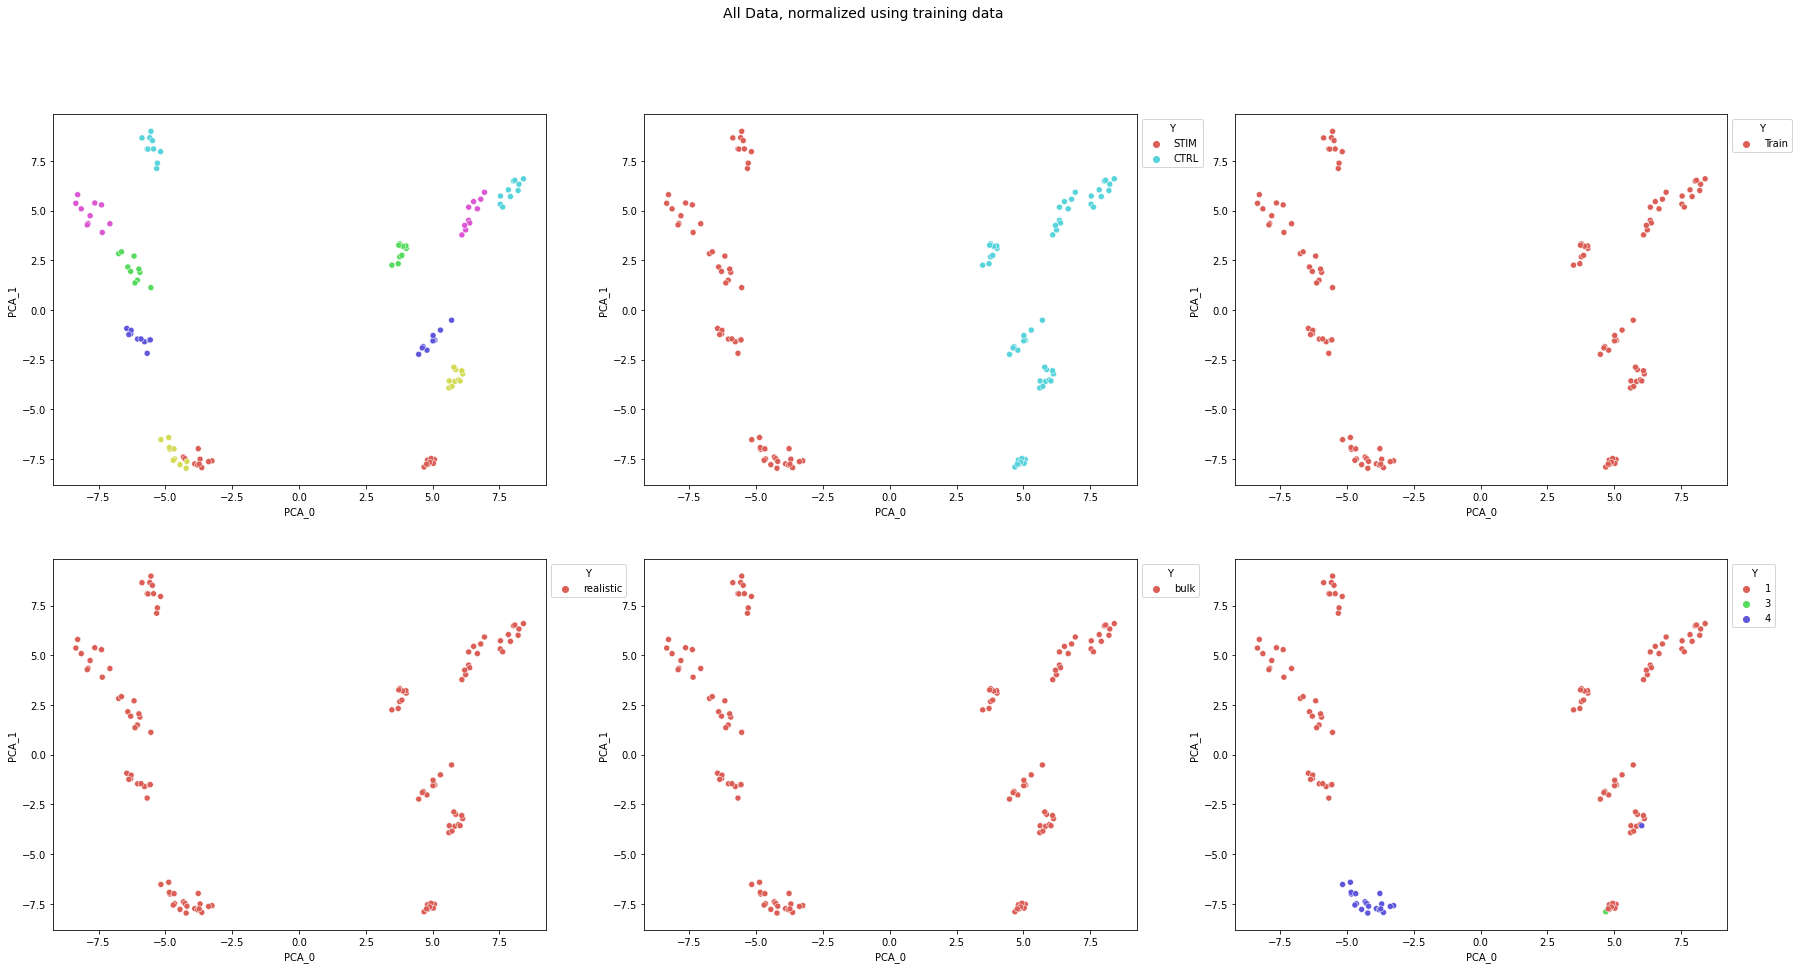

In [11]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 12.872424


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.729401
[t-SNE] KL divergence after 500 iterations: 0.065362
(120, 2)
(120, 2)


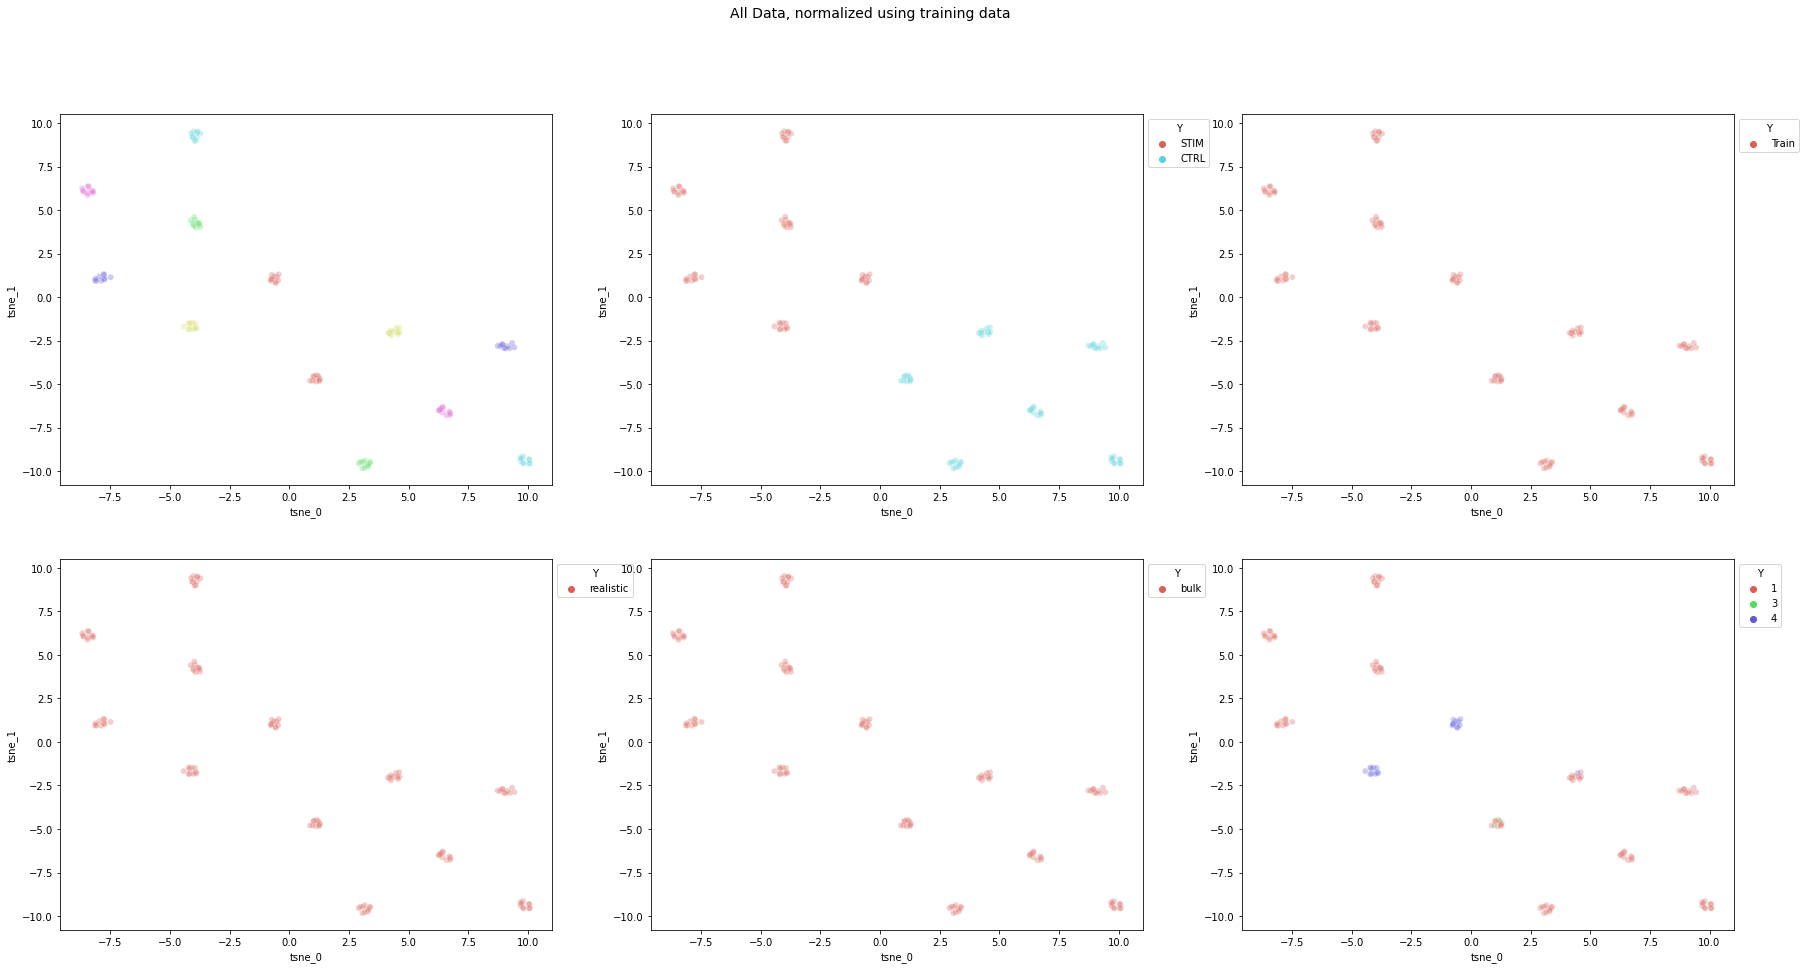

In [12]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read Models**

Using the hyperparameters learned from using the full BuDDI model, train the restricted BuDDI models

In [13]:
from importlib import reload  # Python 3.4+
reload(buddi)
reload(buddi.buddi4)
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/plotting/validation_plotting.py'>

In [14]:
curr_n_epoch=50
curr_wt = 1000


res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_classifier")


res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_classifier")

# **Structured Slack Analysis**

### plotting functions

In [15]:

def plot_slack(encoder_unlab, 
        X_temp, Y_temp, perturb_temp, 
        batch_size, curr_cell="CD14_Mono"):

    z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _  = encoder_unlab.predict(X_temp, batch_size=batch_size)
    
    # get the info from one cell type
    idx_cell_type = np.where(Y_temp == curr_cell)[0]
    curr_mu_slack = mu_slack[idx_cell_type]
    curr_perturb_temp = perturb_temp[idx_cell_type]


    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    # format
    perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
    curr_perturb_temp_str = ["Yes" if x else "No" for x in curr_perturb_temp]
    


    # plot
    plot_df = vp.get_pca_for_plotting(np.asarray(mu_slack))
    vp.plot_pca(plot_df, color_vec=perturb_temp_str, ax=axs[0], 
                title="Slack space -- all bulk samples", alpha=1, legend_title="Perturbed")
    
    plot_df = vp.get_pca_for_plotting(np.asarray(curr_mu_slack))
    vp.plot_pca(plot_df, color_vec=curr_perturb_temp_str, ax=axs[1], 
                title=f"Slack space -- bulk samples with\nmajority cell type predicted to be {curr_cell}", 
                alpha=1, legend_title="Perturbed")


    return fig

def plot_celltype_pert(encoder_unlab, curr_cell_types,
        X_temp, Y_temp, perturb_temp, label_temp,
        batch_size):

    z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _  = encoder_unlab.predict(X_temp, batch_size=batch_size)

    fig, axs = plt.subplots(2, len(curr_cell_types), figsize=(30,15))
    plot_idx = 0
    for curr_cell in curr_cell_types:

        # only get the info from one cell type at a time
        idx_cell_type = np.where(Y_temp == curr_cell)[0]
        curr_mu_slack = mu_slack[idx_cell_type]
        curr_perturb_temp = perturb_temp[idx_cell_type]
        curr_label_temp = label_temp[idx_cell_type]


        # format
        curr_perturb_temp_str = ["Yes" if x  else "No" for x in curr_perturb_temp ]

        # continue if missing
        if len(idx_cell_type) == 0:
            continue

        # plot
        plot_df = vp.get_pca_for_plotting(np.asarray(curr_mu_slack))
        vp.plot_pca(plot_df, color_vec=curr_perturb_temp_str, ax=axs[0,plot_idx], title=curr_cell, alpha=1, legend_title="Perturbed")
        vp.plot_pca(plot_df, color_vec=curr_label_temp, ax=axs[1,plot_idx], title="", alpha=1, legend_title="Sample IDs")

        plot_idx = plot_idx +1


    fig.show()


    return fig


### plot slack

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(500, 2)
(500, 2)
(292, 2)
(292, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(500, 2)
(500, 2)
(292, 2)
(292, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(500, 2)
(500, 2)
(292, 2)
(292, 2)


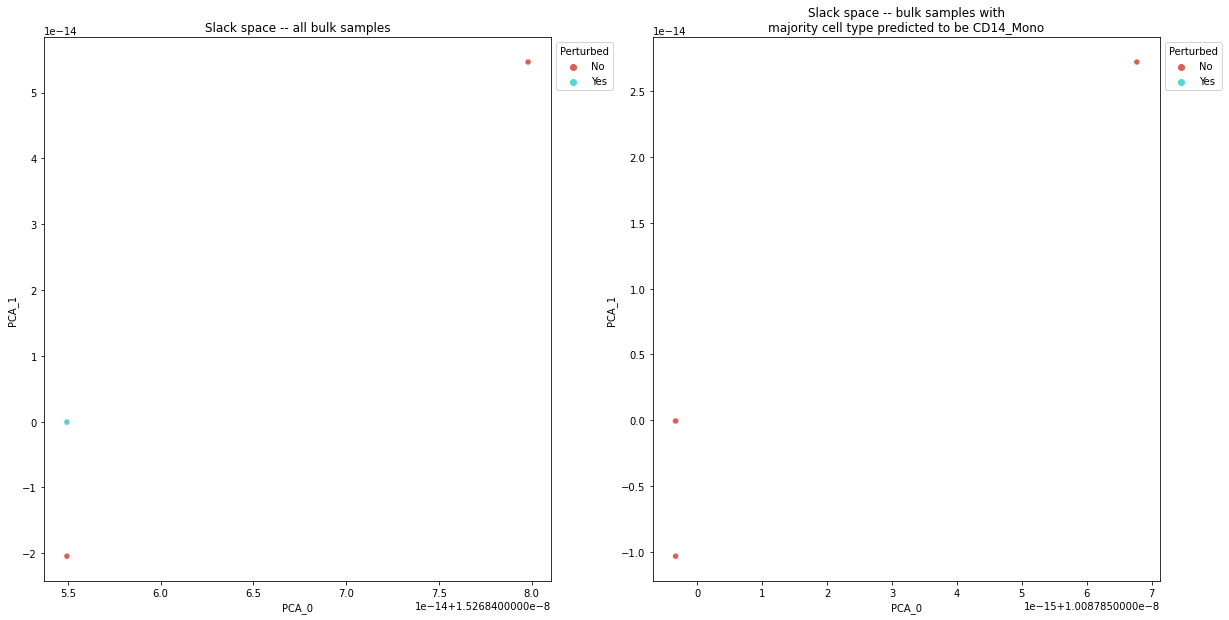

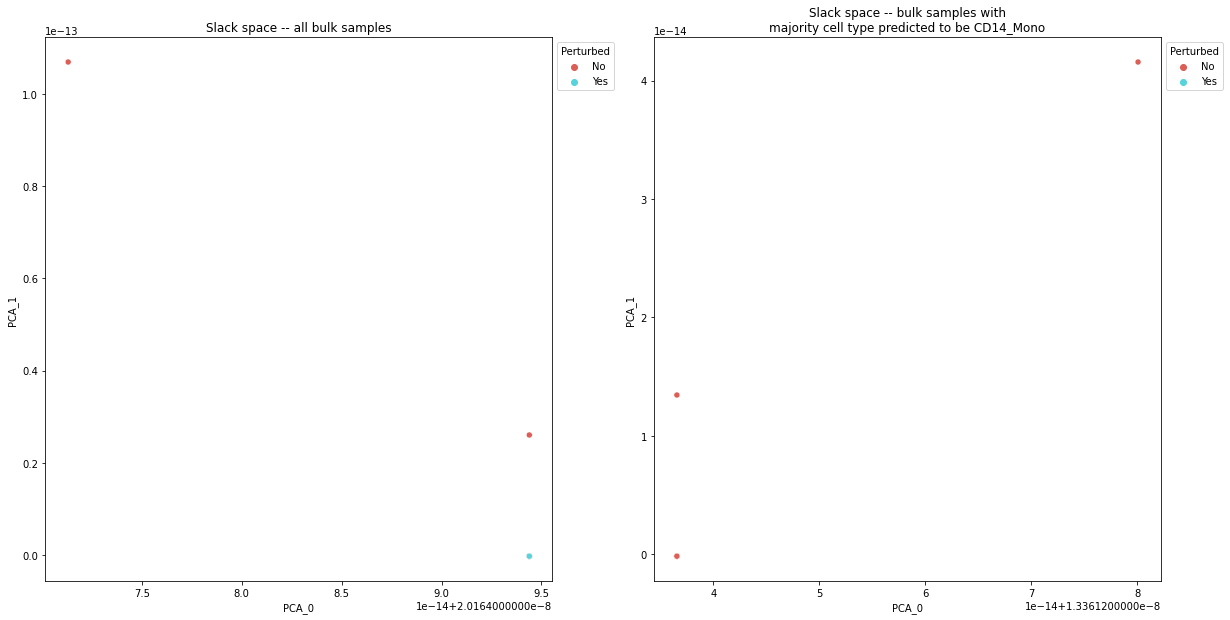

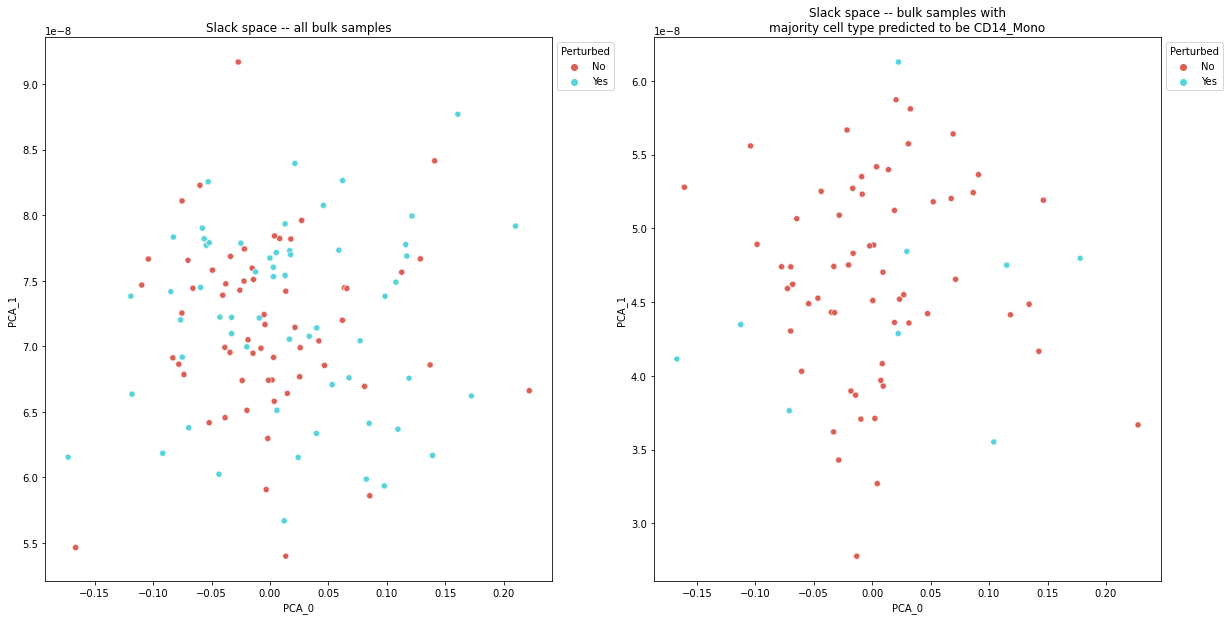

In [16]:

idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


prop_outputs = res1_classifier.predict(X_temp, batch_size=500)
Y_pert = np.copy(prop_outputs)
Y_pert = np.argmax(Y_pert, axis=1)
Y_temp = Y_full.columns[Y_pert]

true_prop_df = Y_full.iloc[idx_tmp]


label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


res1_latent_plot = plot_slack(res1_enc_unlab,
                        X_temp, Y_temp, perturb_temp, 
                        batch_size=500, curr_cell="CD14_Mono")



res2_latent_plot = plot_slack(res2_enc_unlab,
                        X_temp, Y_temp, perturb_temp, 
                        batch_size=500, curr_cell="CD14_Mono")



res3_latent_plot = plot_slack(res3_enc_unlab,
                        X_temp, Y_temp, perturb_temp, 
                        batch_size=500, curr_cell="CD14_Mono")

(299, 2)
(299, 2)
(127, 2)
(127, 2)


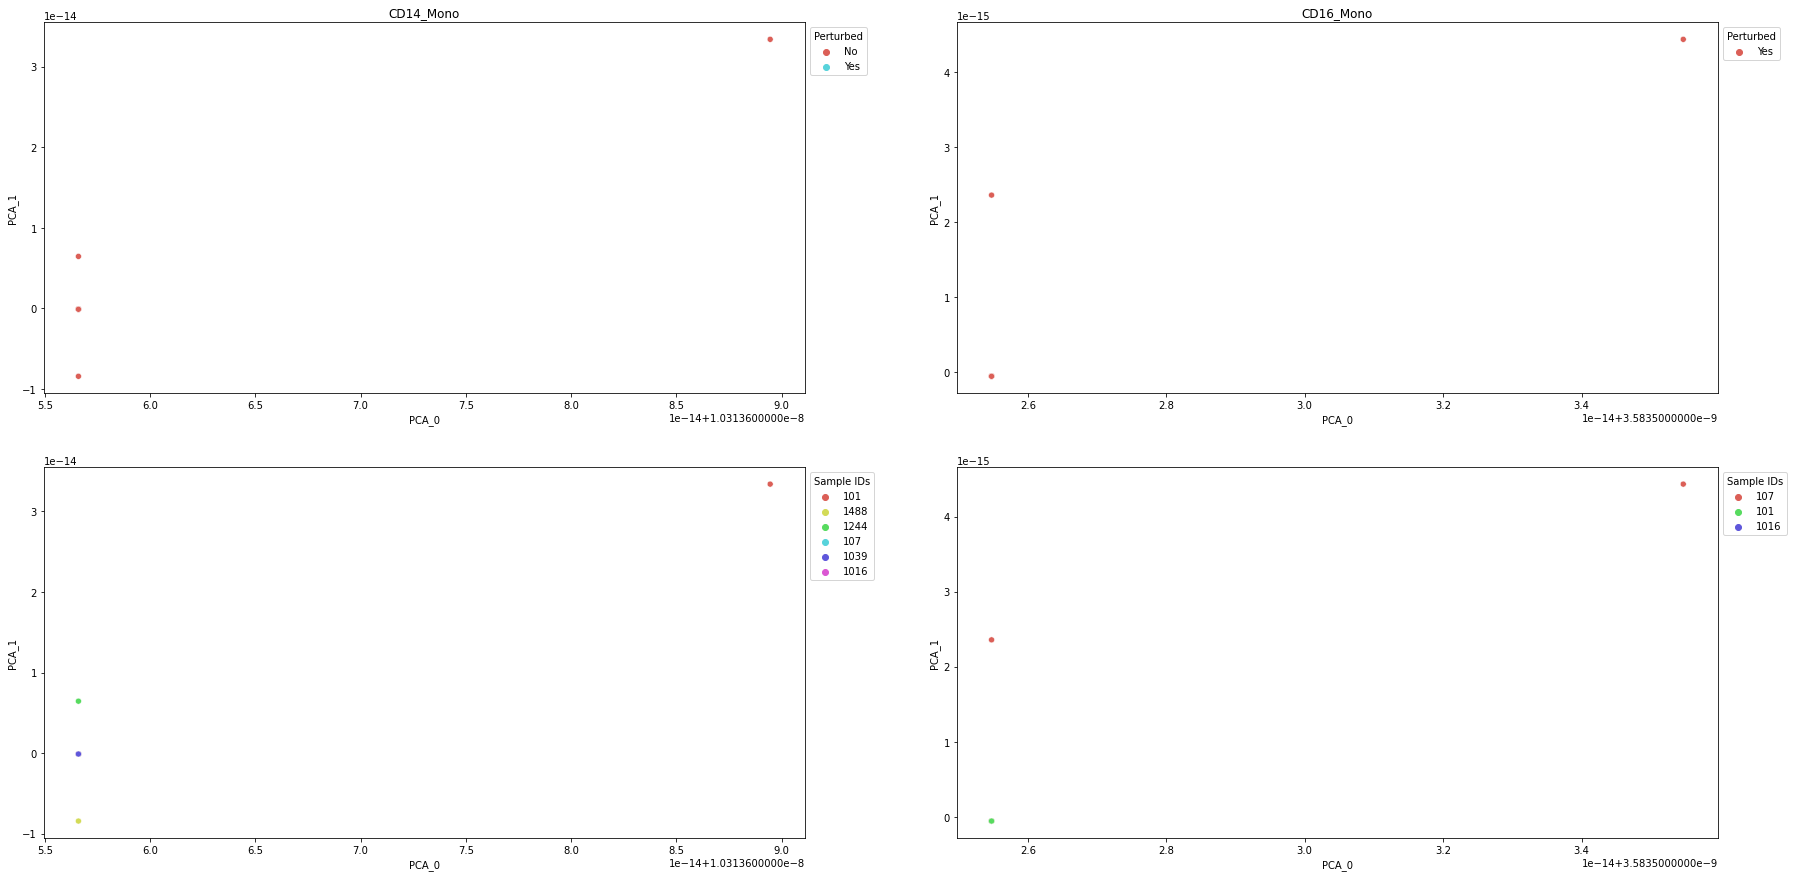

In [17]:

idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


prop_outputs = res1_classifier.predict(X_temp, batch_size=500)
Y_pert = np.copy(prop_outputs)
Y_pert = np.argmax(Y_pert, axis=1)
Y_temp = Y_full.columns[Y_pert]

true_prop_df = Y_full.iloc[idx_tmp]


label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

curr_cell_types = ["CD14_Mono", "CD16_Mono"]
res1_latent_plot = plot_celltype_pert(res1_enc_unlab, curr_cell_types, 
                        X_temp, Y_temp, perturb_temp, label_temp, 
                        batch_size=500)



### plot all latent spaces

(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


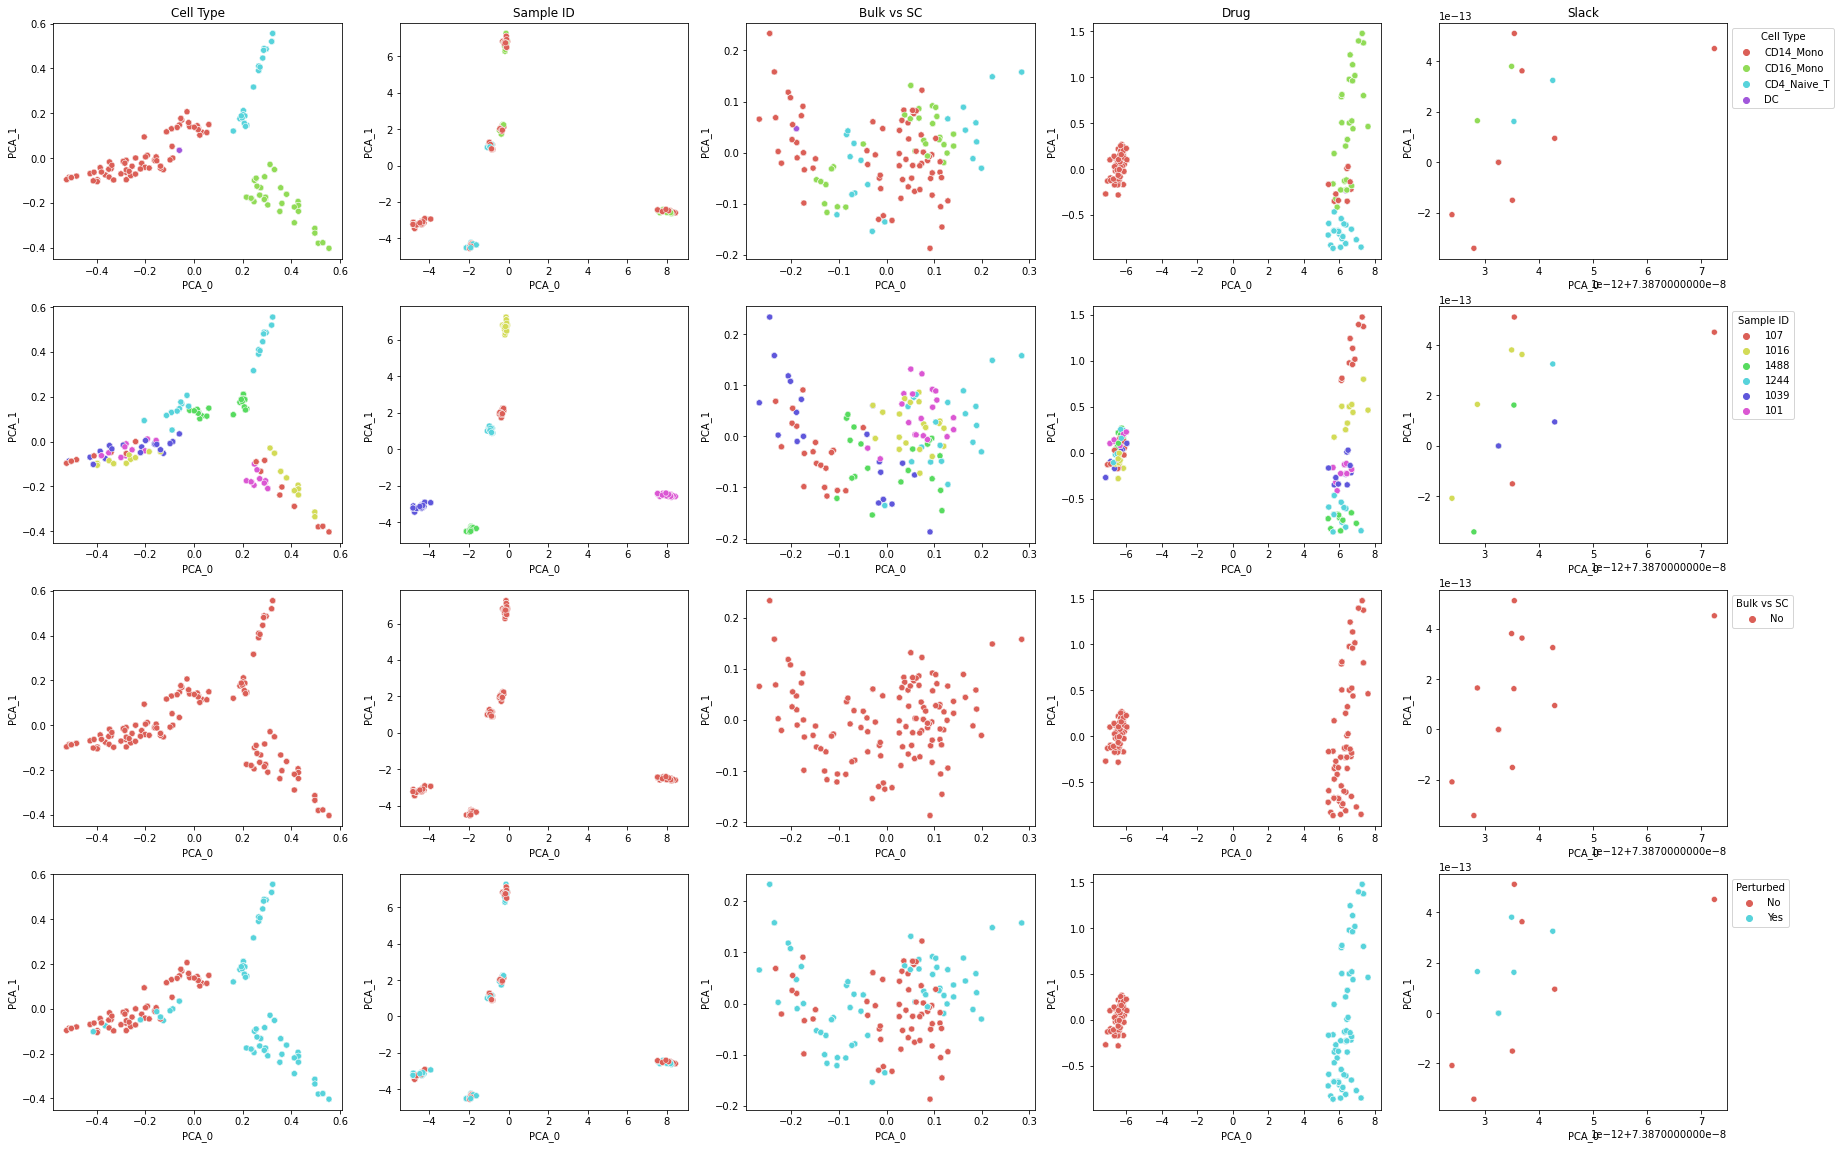

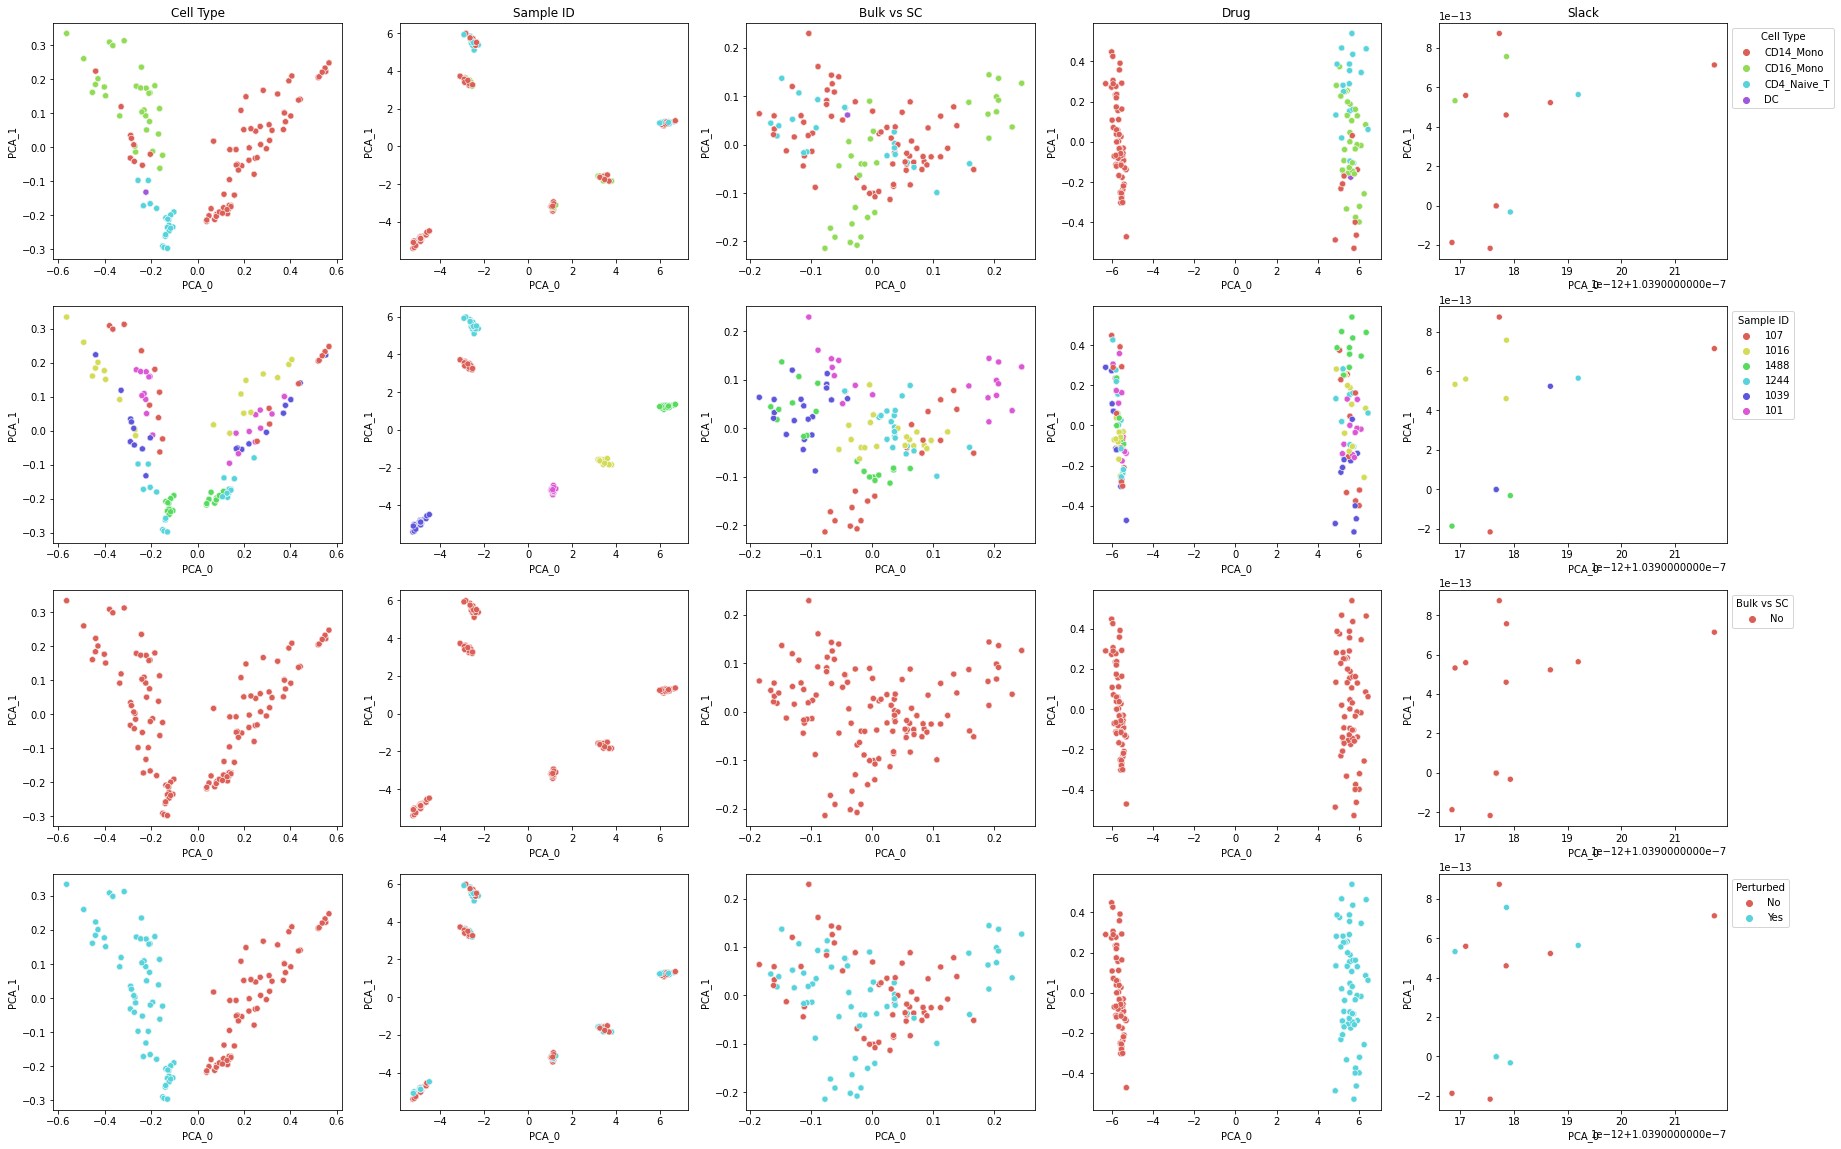

In [18]:
# now plot with predictions
# cell type proportion labels
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 2500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


# make predictions
prop_outputs = res1_classifier.predict(X_temp, batch_size=500)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

# format
perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
bulk_temp_str = ["Yes" if x else "No" for x in bulk_temp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)


res2_latent_plot = buddi.plot_latent_spaces(res2_enc_unlab, res2_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)


res3_latent_plot = buddi.plot_latent_spaces(res3_enc_unlab, res3_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)

(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)


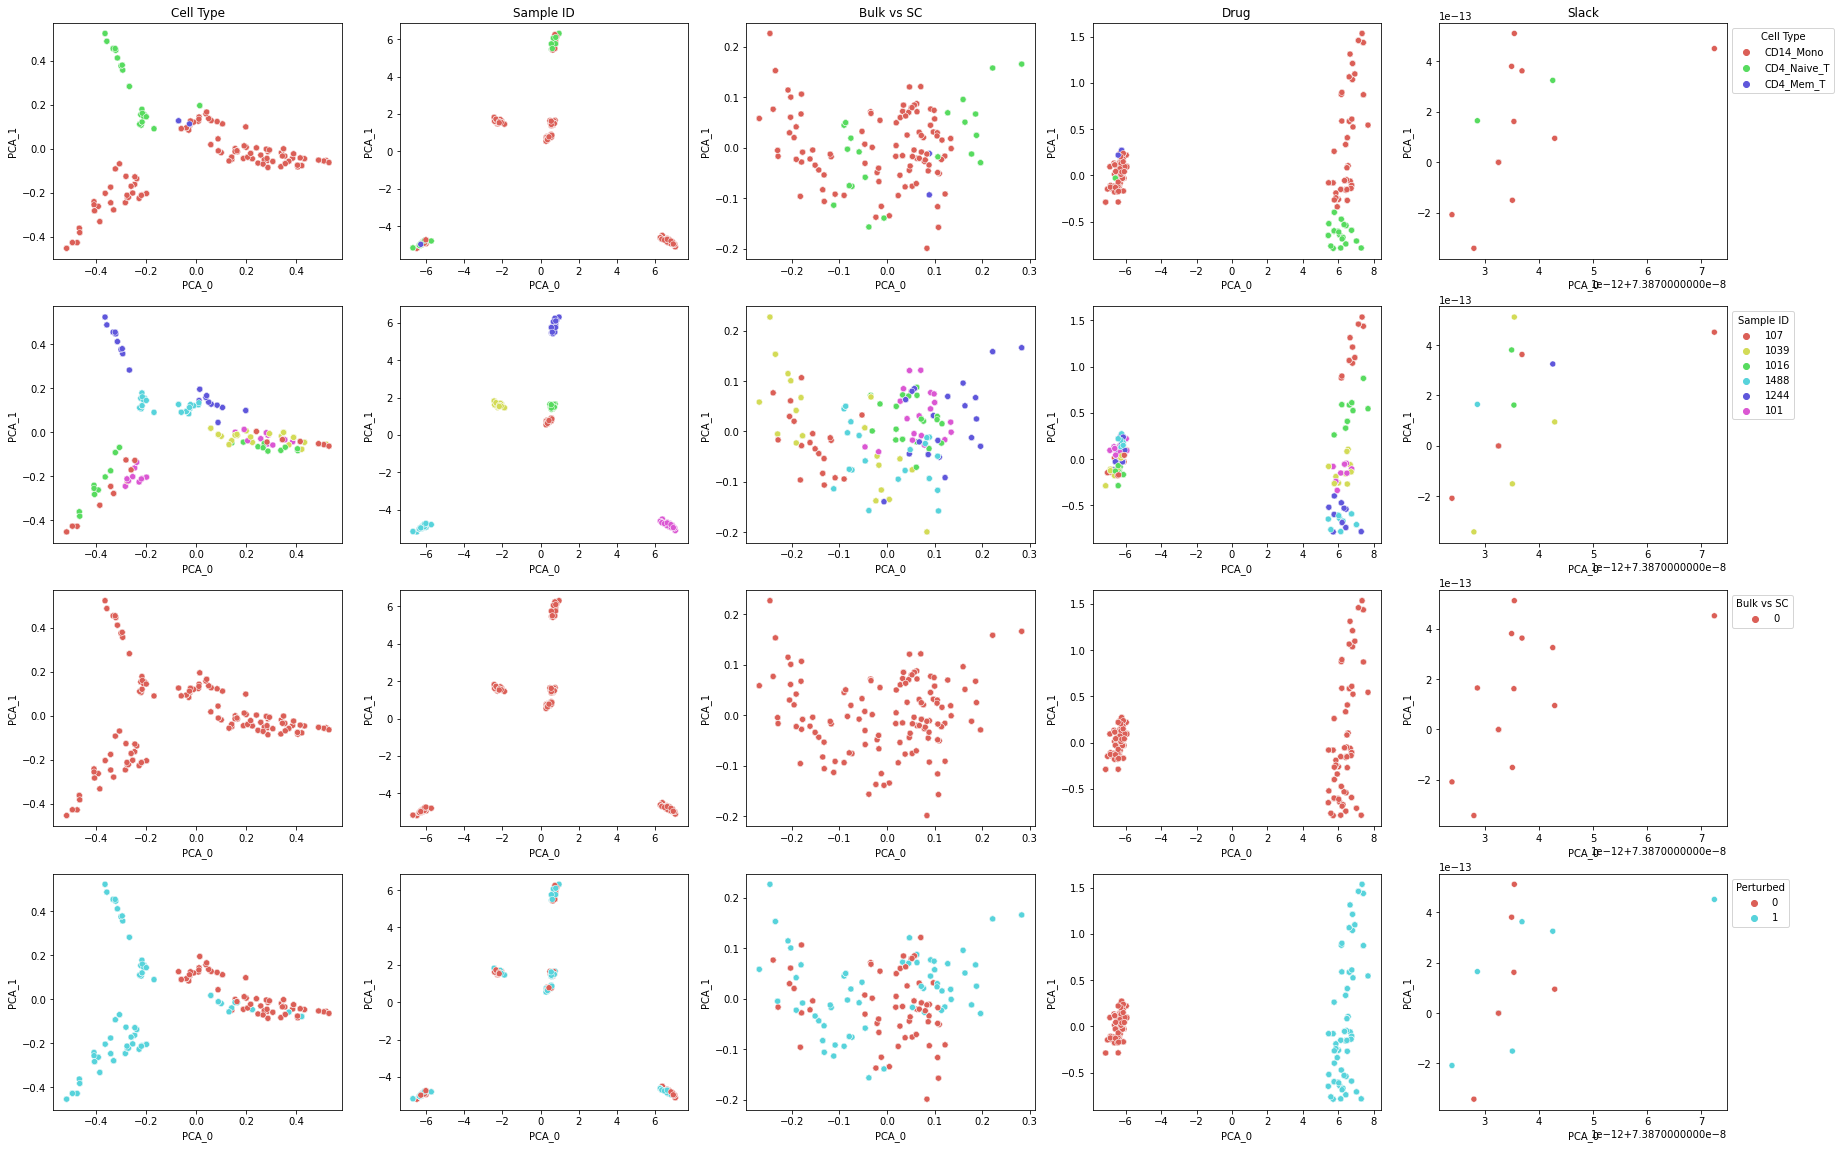

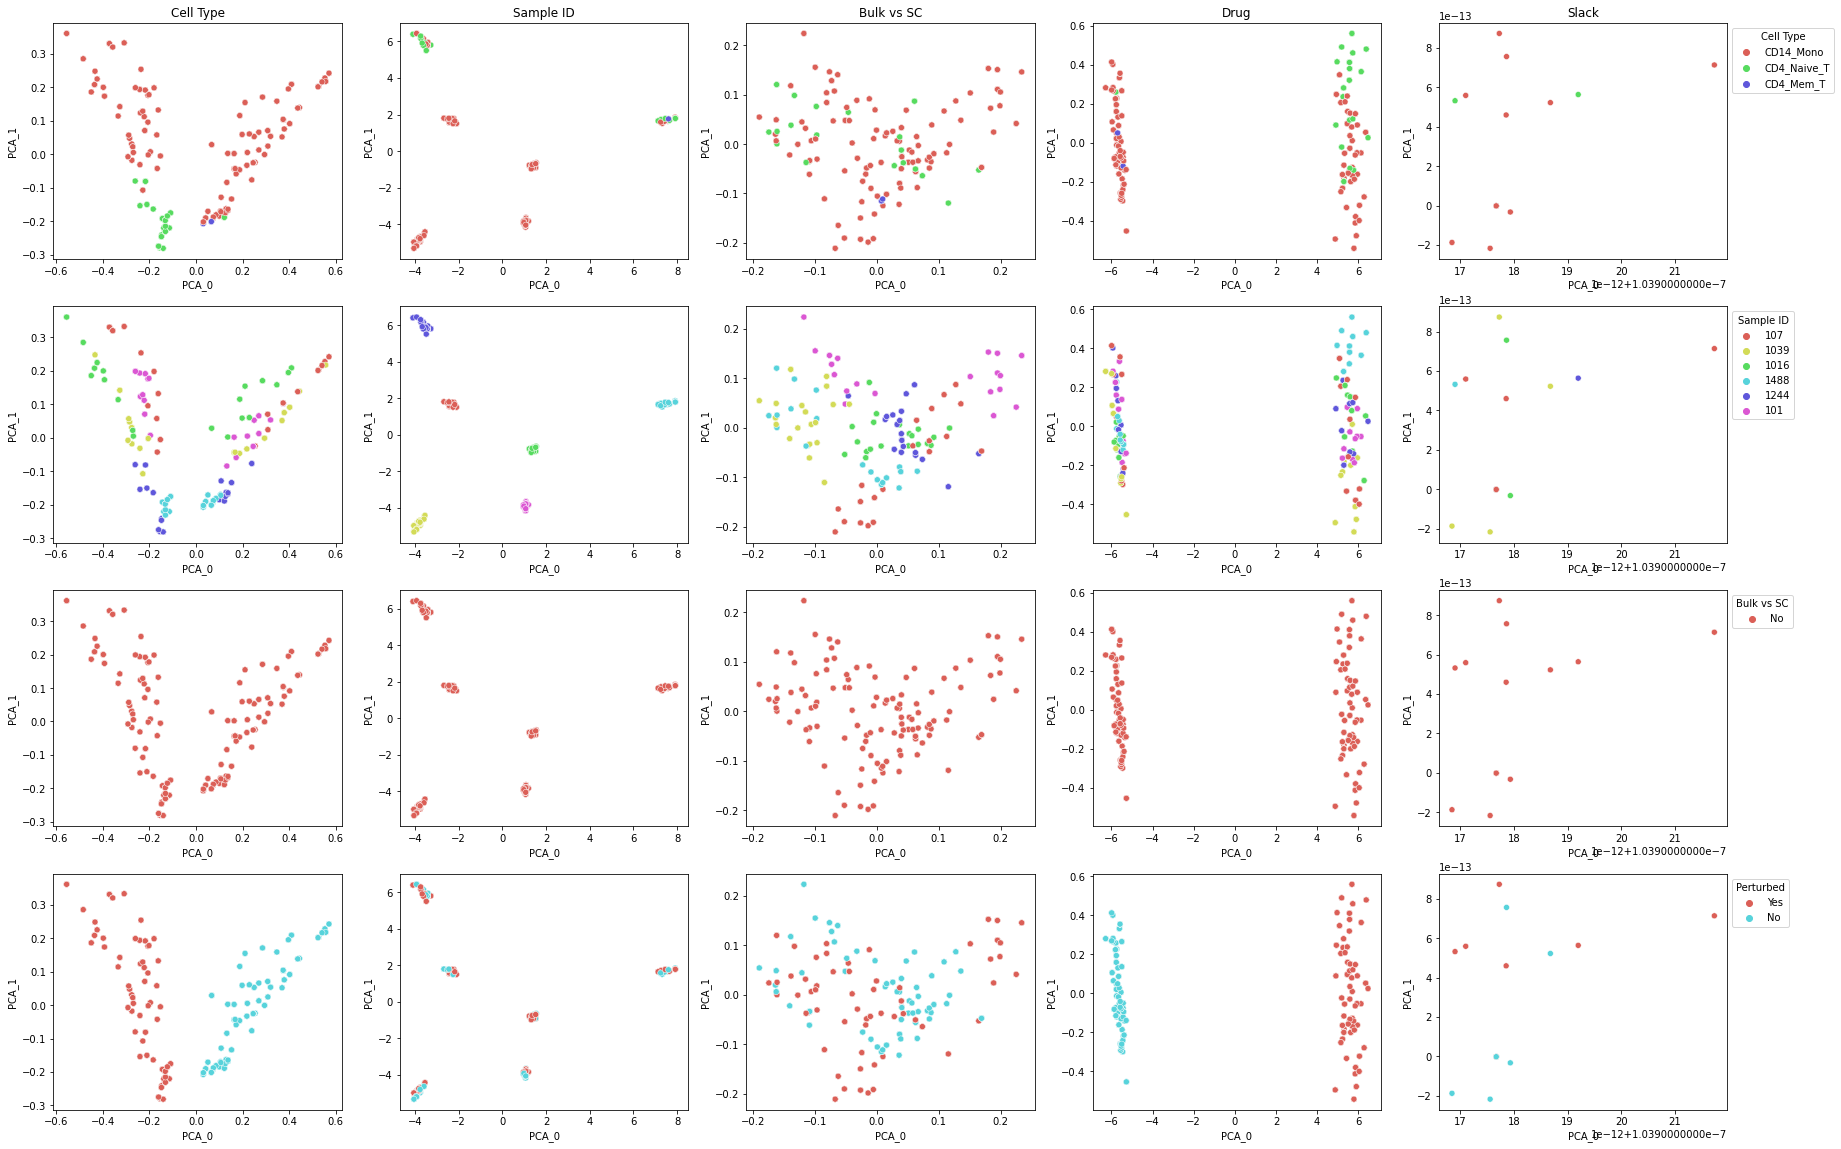

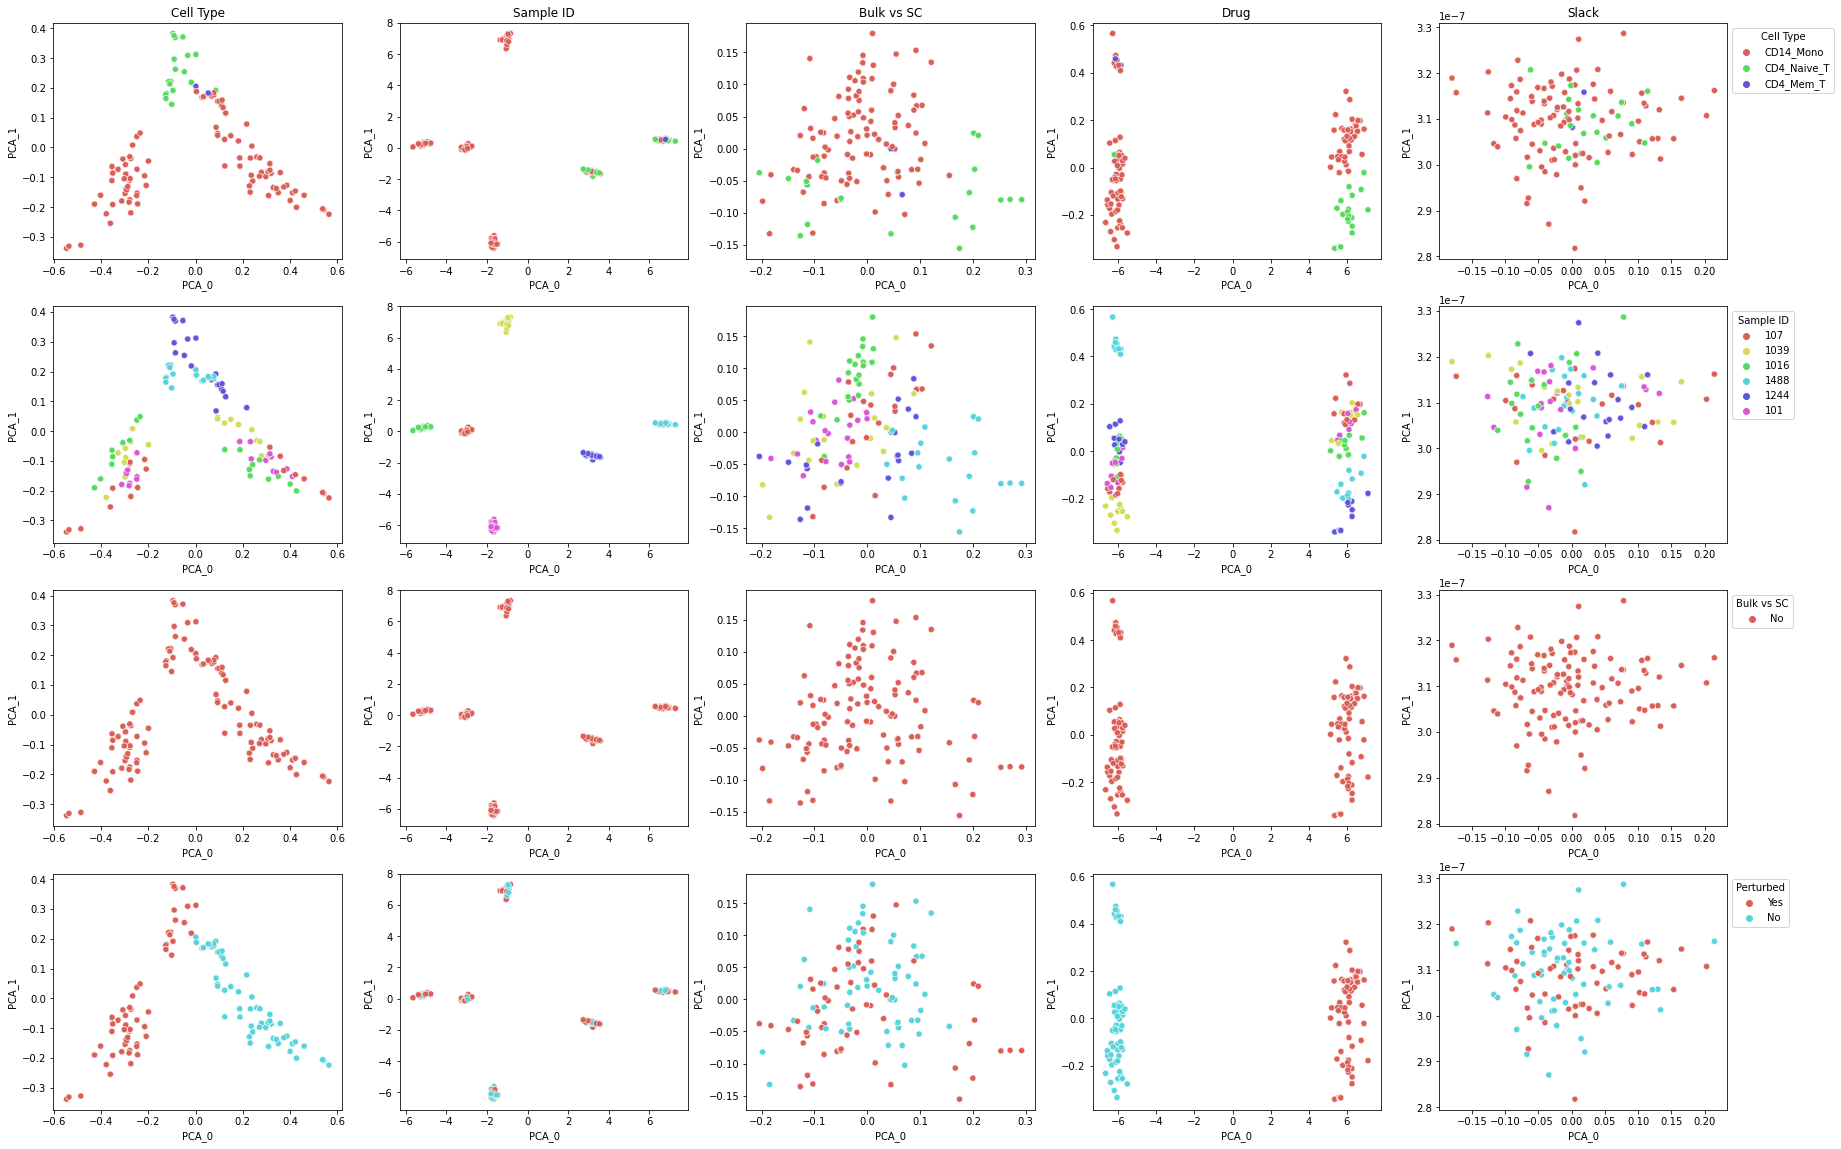

In [ ]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 2500, replace=True)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

# format
perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
bulk_temp_str = ["Yes" if x else "No" for x in bulk_temp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)


res2_latent_plot = buddi.plot_latent_spaces(res2_enc_unlab, res2_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)


res3_latent_plot = buddi.plot_latent_spaces(res3_enc_unlab, res3_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)

### plot all latent spaces and all training data

(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


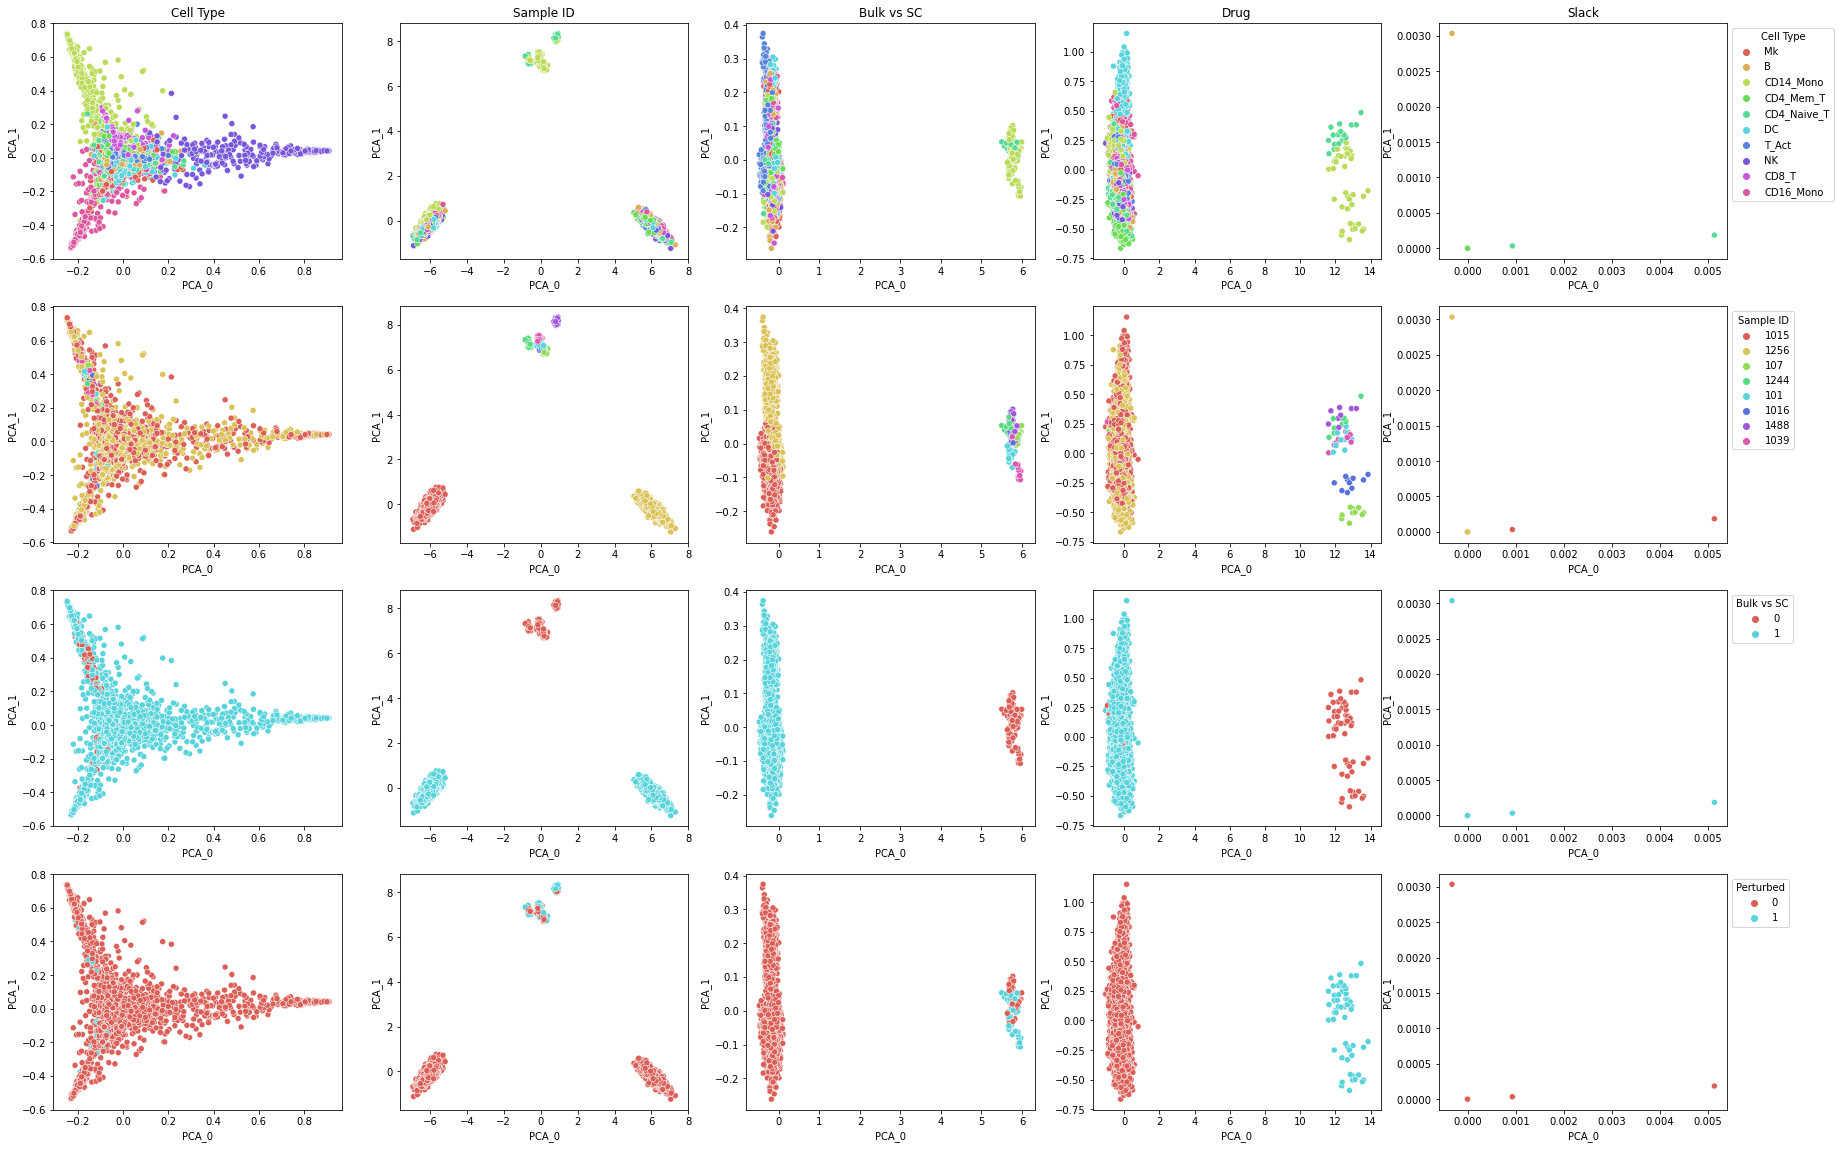

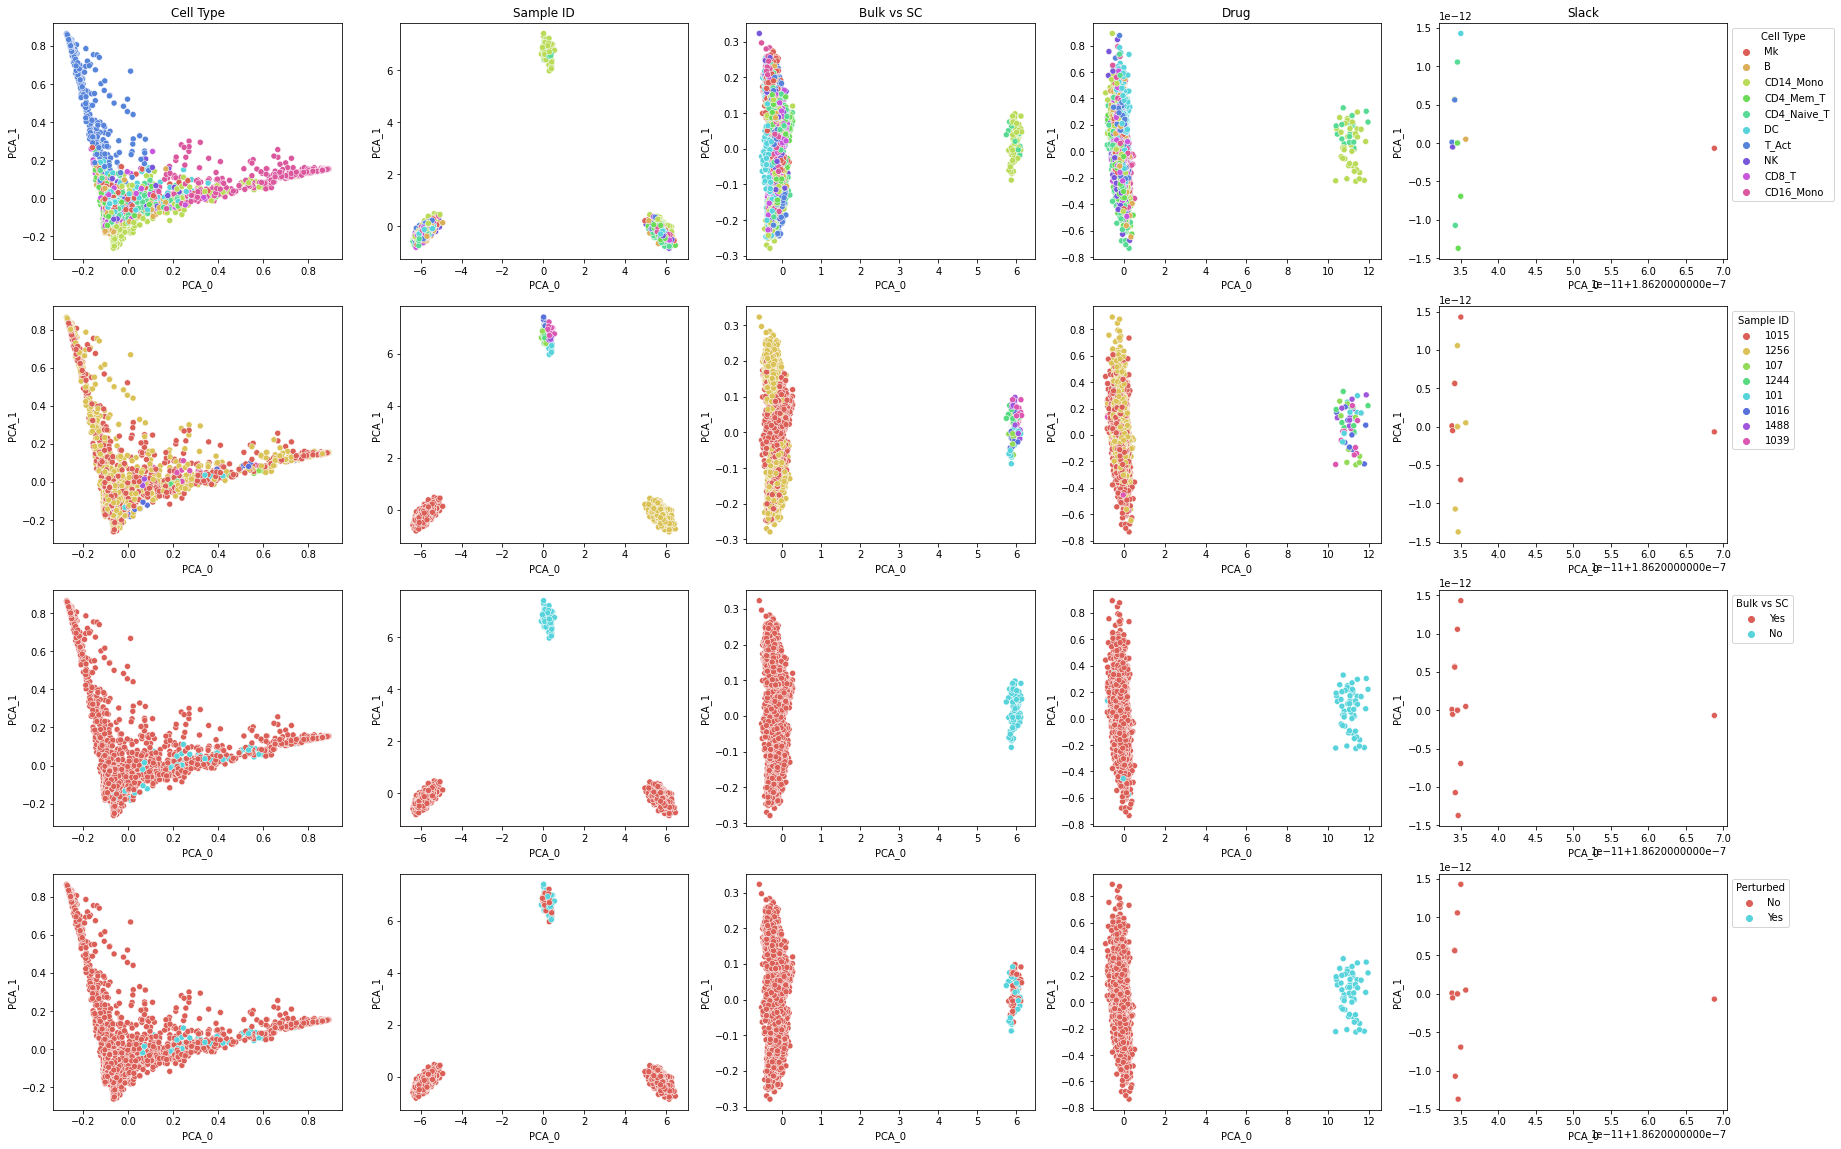

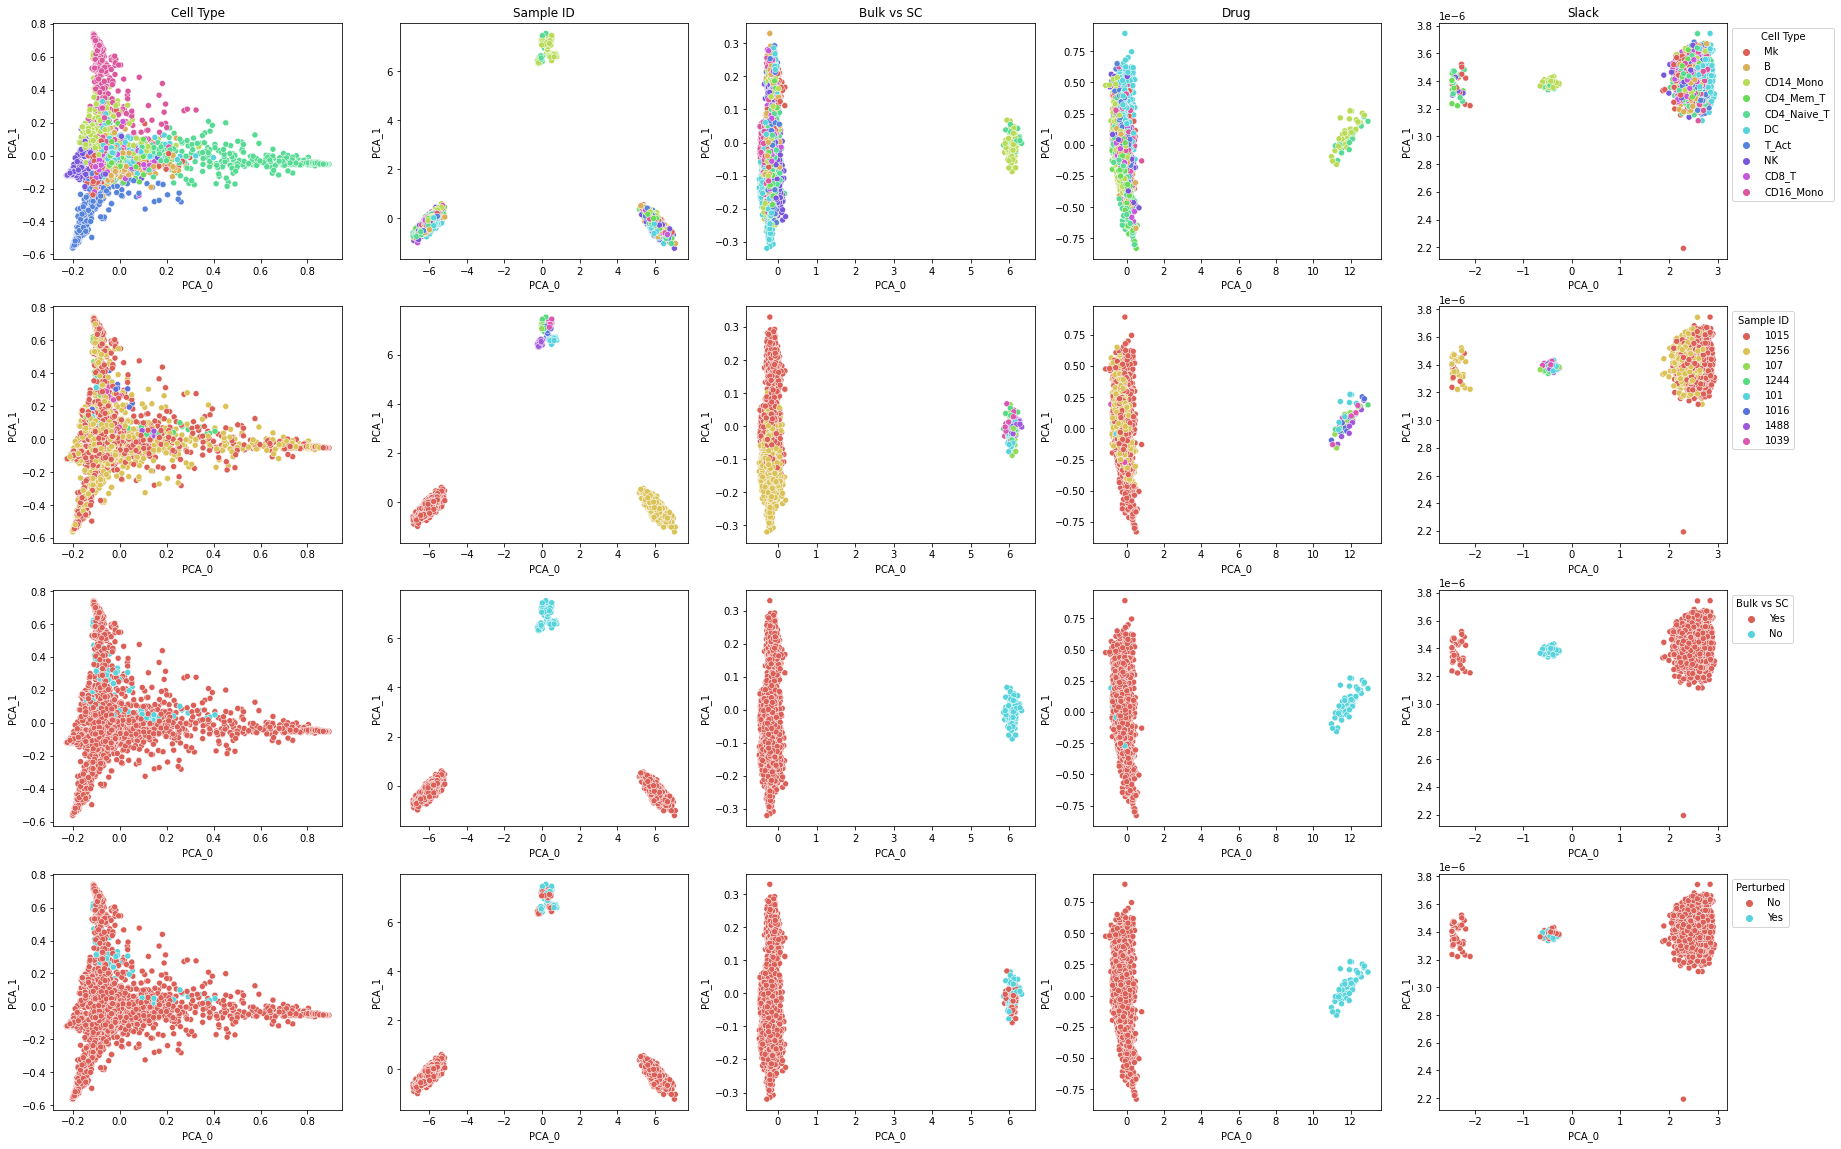

In [ ]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 4000, replace=False)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

# format
perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
bulk_temp_str = ["Yes" if x else "No" for x in bulk_temp]


res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True)

res2_latent_plot = buddi.plot_latent_spaces(res2_enc_unlab, res2_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)


res3_latent_plot = buddi.plot_latent_spaces(res3_enc_unlab, res3_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp_str, bulk_temp_str, 
                        batch_size=500, use_buddi4=True)

In [ ]:
plot_df

PCA_0     PCA_1    Cell Type
0    -0.025693 -0.219666        T_Act
1    -0.122437 -0.052466           Mk
2    -0.023969 -0.103574        T_Act
3    -0.231999  0.662018    CD16_Mono
4    -0.136304 -0.068384           Mk
...        ...       ...          ...
3995 -0.002866 -0.200632        T_Act
3996 -0.149997 -0.182200    CD14_Mono
3997 -0.258732  0.625280    CD16_Mono
3998 -0.047055 -0.171266  CD4_Naive_T
3999 -0.050169 -0.107813    CD4_Mem_T

[4000 rows x 3 columns]

(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


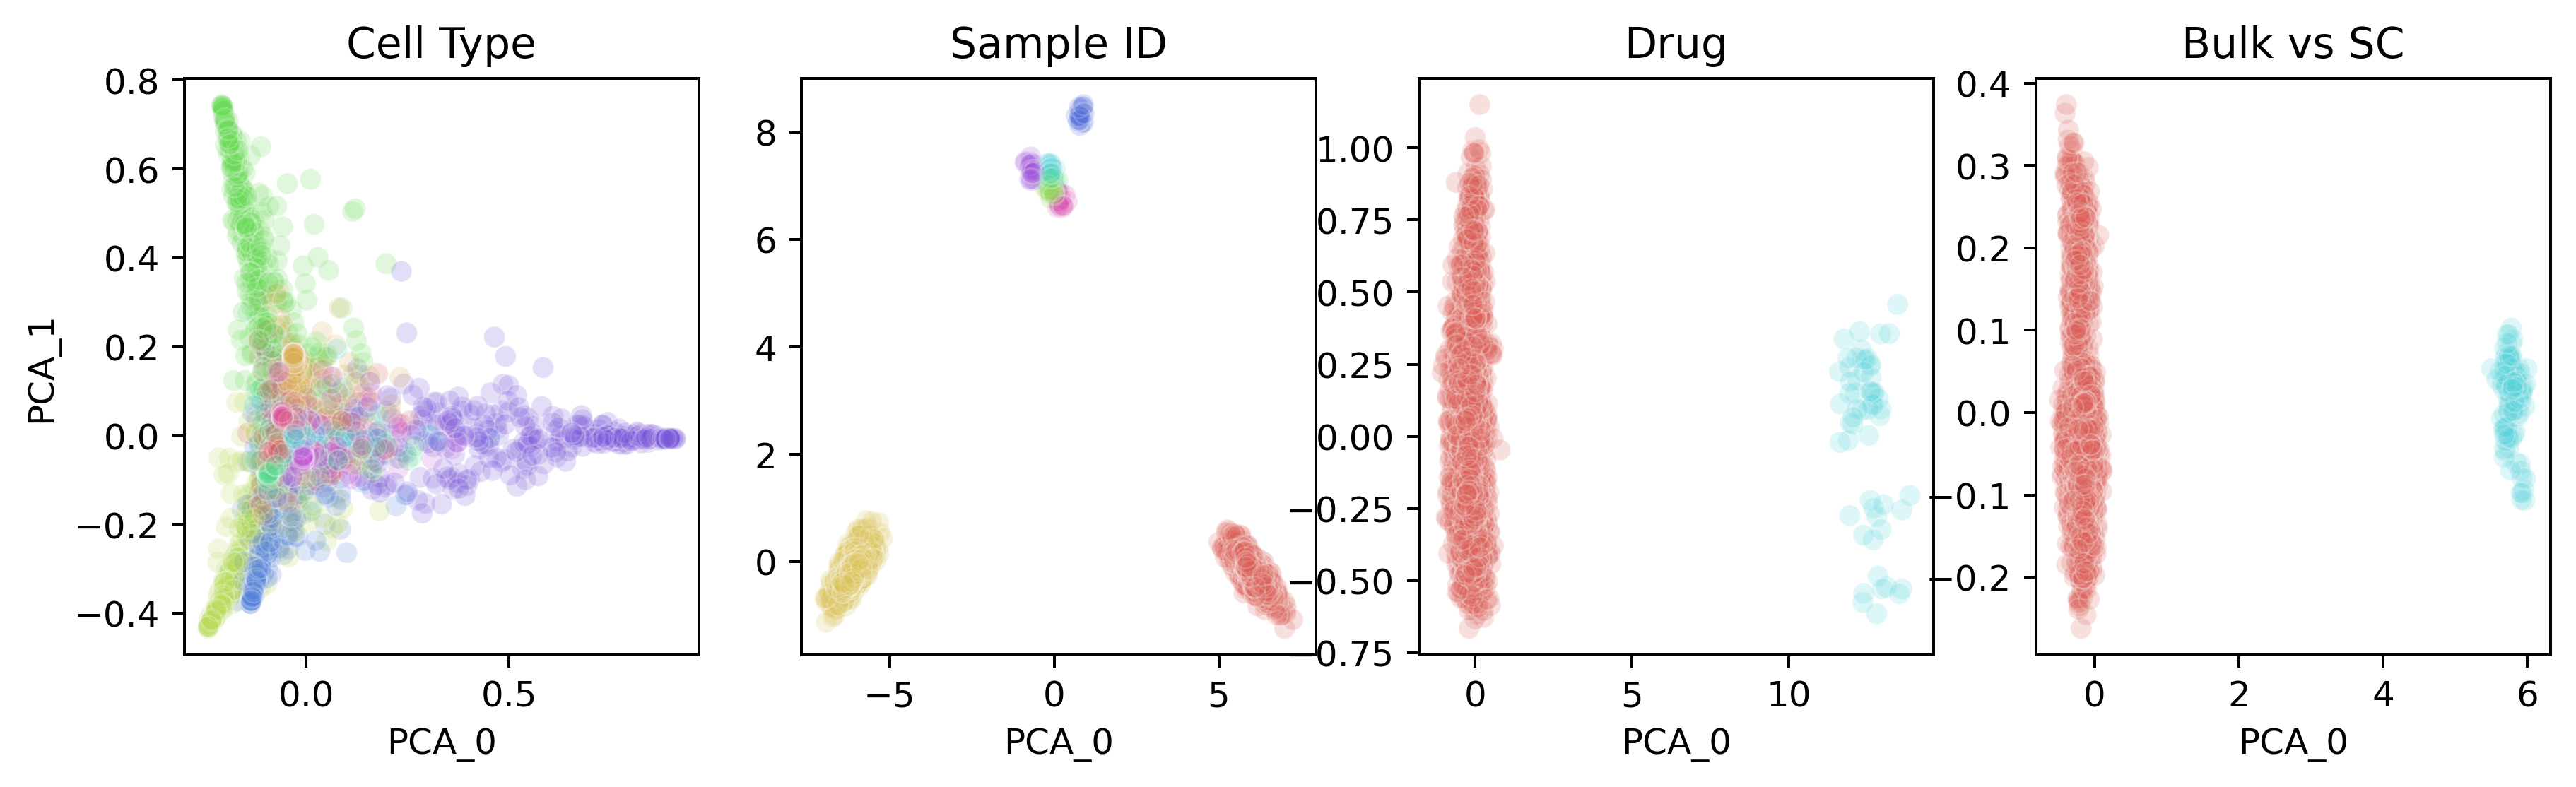

In [ ]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 4000, replace=False)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

# format
perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
bulk_temp_str = ["Yes" if x else "No" for x in bulk_temp]


z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_temp, batch_size=500)
prop_outputs = res1_classifier.predict(X_temp, batch_size=500)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug, z_bulk])

alpha = 0.2

fig, axs = plt.subplots(1, 4, figsize=(12,3), dpi=360)

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="Cell Type", alpha=alpha, legend_title="Cell Type")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1], title="Sample ID", alpha=alpha, legend_title="Sample ID")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=perturb_temp_str, ax=axs[2], title="Drug", alpha=alpha, legend_title="Perturbed")


plot_df = vp.get_pca_for_plotting(np.asarray(mu_bulk))
vp.plot_pca(plot_df, color_vec=bulk_temp_str, ax=axs[3], title="Bulk vs SC", alpha=alpha, legend_title="Bulk vs SC")

axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()

y_axis = axs[1].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

y_axis = axs[2].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

y_axis = axs[3].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)





(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)
(4000, 2)


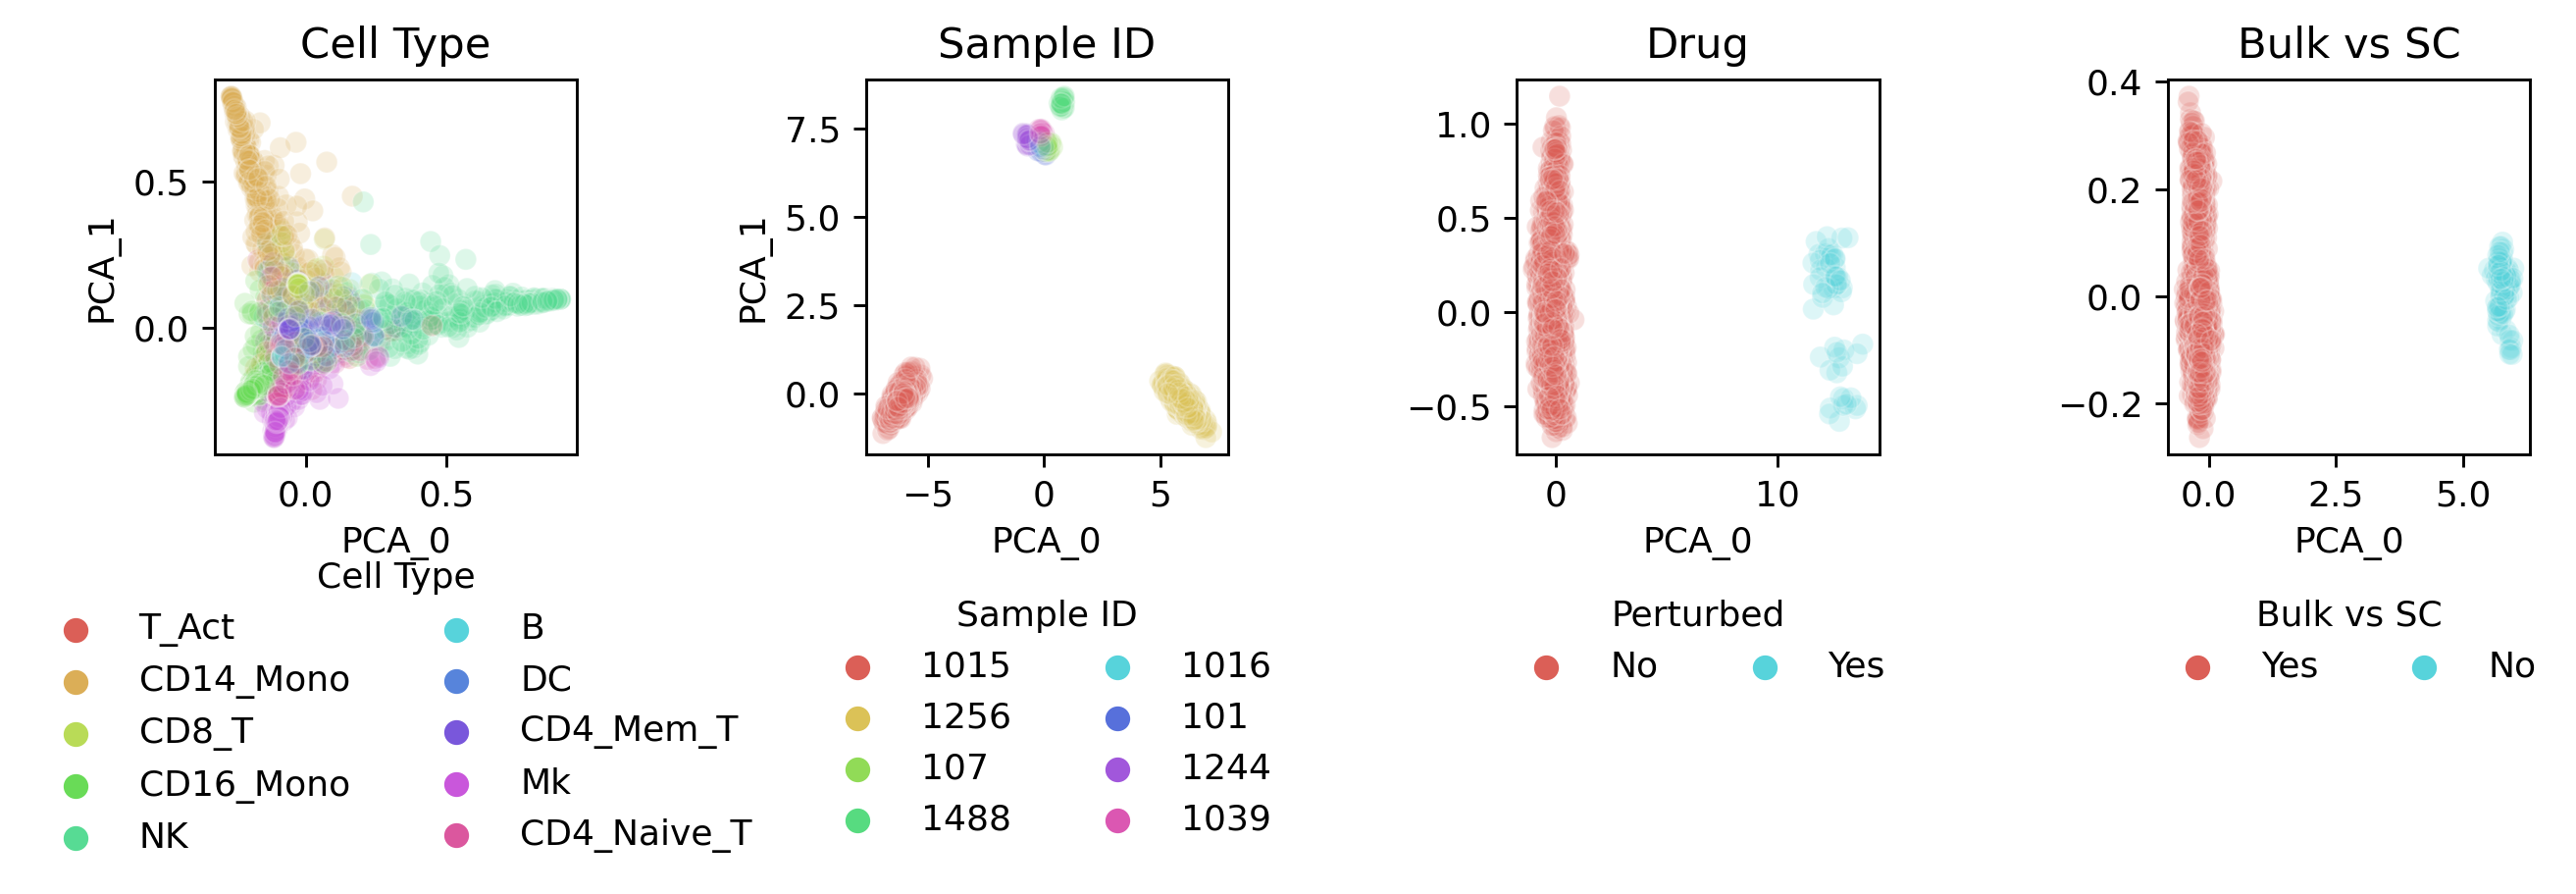

In [ ]:
# now plot with ground truth
# cell type proportion labels
idx_tmp = np.where(meta_df.isTraining == "Train")[0]
idx_tmp = np.random.choice(idx_tmp, 4000, replace=False)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]


Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]

# format
perturb_temp_str = ["Yes" if x else "No" for x in perturb_temp]
bulk_temp_str = ["Yes" if x else "No" for x in bulk_temp]


z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_temp, batch_size=500)
prop_outputs = res1_classifier.predict(X_temp, batch_size=500)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug, z_bulk])

alpha = 0.2

fig, axs = plt.subplots(1, 4, figsize=(10,4), dpi=260)

plot_df = vp.get_pca_for_plotting(np.asarray(prop_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="Cell Type", alpha=alpha, legend_title="Cell Type")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_rot))
vp.plot_pca(plot_df, color_vec=label_temp, ax=axs[1], title="Sample ID", alpha=alpha, legend_title="Sample ID")

plot_df = vp.get_pca_for_plotting(np.asarray(mu_drug))
vp.plot_pca(plot_df, color_vec=perturb_temp_str, ax=axs[2], title="Drug", alpha=alpha, legend_title="Perturbed")


plot_df = vp.get_pca_for_plotting(np.asarray(mu_bulk))
vp.plot_pca(plot_df, color_vec=bulk_temp_str, ax=axs[3], title="Bulk vs SC", alpha=alpha, legend_title="Bulk vs SC")


sns.move_legend(
    axs[0], "upper center",
    bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False,
)
sns.move_legend(
    axs[1], "upper center",
    bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False,
)
sns.move_legend(
    axs[2], "upper center",
    bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False,
)
sns.move_legend(
    axs[3], "upper center",
    bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False,
)

y_axis = axs[2].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)


y_axis = axs[3].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)


fig.tight_layout()


# **Get RF prediction scores**

In [ ]:
# NOW predict most abundant cell type
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB

def run_RF(X_in, Y_in):

    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
    _, index = sss.split(X_in, Y_in)
    x_rf_train, y_rf_train = X_in[index[1]], Y_in[index[1]]
    x_rf_test, y_rf_test = X_in[index[0]], Y_in[index[0]]

    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_rf_train, y_rf_train)
    y_rf_pred = clf.predict(x_rf_test)
    out_f1 = np.median(f1_score(y_rf_test, y_rf_pred, average=None))

    return out_f1

def run_NB(X_in, Y_in):

    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
    _, index = sss.split(X_in, Y_in)
    x_rf_train, y_rf_train = X_in[index[1]], Y_in[index[1]]
    x_rf_test, y_rf_test = X_in[index[0]], Y_in[index[0]]

    clf = GaussianNB()
    clf.fit(x_rf_train, y_rf_train)
    y_rf_pred = clf.predict(x_rf_test)
    out_f1 = np.median(f1_score(y_rf_test, y_rf_pred, average=None))

    return out_f1

def run_buddi4_RF(enc_unlab, classifier, 
                  X_tmp, Y_temp, label_temp, perturb_temp, bulk_temp):

    # get encodings
    z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _  = enc_unlab.predict(X_tmp, batch_size=500)

    # make predictions
    prop_outputs = classifier.predict(X_tmp, batch_size=500)



    ########
    ## using drug_outputs
    ########

    prop_y_f1 = run_NB(prop_outputs, Y_temp)
    prop_lab_f1 = run_NB(prop_outputs, label_temp)
    prop_pert_f1 = run_NB(prop_outputs, perturb_temp)
    prop_bulk_f1 = run_NB(prop_outputs, bulk_temp)

    ########
    ## using mu_rot
    ########

    samp_y_f1 = run_NB(mu_rot, Y_temp)
    samp_lab_f1 = run_NB(mu_rot, label_temp)
    samp_pert_f1 = run_NB(mu_rot, perturb_temp)
    samp_bulk_f1 = run_NB(mu_rot, bulk_temp)


    ########
    ## using mu_drug
    ########

    drug_y_f1 = run_NB(mu_drug, Y_temp)
    drug_lab_f1 = run_NB(mu_drug, label_temp)
    drug_pert_f1 = run_NB(mu_drug, perturb_temp)
    drug_bulk_f1 = run_NB(mu_drug, bulk_temp)


    ########
    ## using mu_bulk
    ########

    bulk_y_f1 = run_NB(mu_bulk, Y_temp)
    bulk_lab_f1 = run_NB(mu_bulk, label_temp)
    bulk_pert_f1 = run_NB(mu_bulk, perturb_temp)
    bulk_bulk_f1 = run_NB(mu_bulk, bulk_temp)


    ########
    ## using mu_drug
    ########

    slack_y_f1 = run_NB(mu_slack, Y_temp)
    slack_lab_f1 = run_NB(mu_slack, label_temp)
    slack_pert_f1 = run_NB(mu_slack, perturb_temp)
    slack_bulk_f1 = run_NB(mu_slack, bulk_temp)


    rf_f1_df = pd.DataFrame(np.array([[prop_y_f1, prop_lab_f1, prop_pert_f1, prop_bulk_f1], 
                                        [samp_y_f1, samp_lab_f1, samp_pert_f1, samp_bulk_f1], 
                                        [drug_y_f1, drug_lab_f1, drug_pert_f1, drug_bulk_f1], 
                                        [bulk_y_f1, bulk_lab_f1, bulk_pert_f1, bulk_bulk_f1], 
                                        [slack_y_f1, slack_lab_f1, slack_pert_f1, slack_bulk_f1]]),
                    columns=["cell_type", "sample_id", "perturbed", "bulk"])
    
    rf_f1_df = rf_f1_df.transpose()
    rf_f1_df.columns = ["cell_type", "sample_id", "perturbed", "bulk", "slack"]

    return rf_f1_df


In [ ]:
# Now predict
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Test", meta_df.samp_type == "bulk"))[0]
idx_tmp = np.where(meta_df.isTraining == "Test")[0]
idx_tmp = np.random.choice(idx_tmp, 8000, replace=False)


X_tmp = X_full[idx_tmp,]

# get the labels of interest for prediction
# then make 1-hot encoded
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

Y_temp_1hot = np.zeros((Y_temp.size, Y_temp.max() + 1))
Y_temp_1hot[np.arange(Y_temp.size), Y_temp] = 1

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp_1hot = np.zeros((label_temp.size, label_temp.max() + 1))
label_temp_1hot[np.arange(label_temp.size), label_temp] = 1


perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]
perturb_temp_1hot = np.zeros((perturb_temp.size, perturb_temp.max() + 1))
perturb_temp_1hot[np.arange(perturb_temp.size), perturb_temp] = 1


bulk_temp =np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]
bulk_temp_1hot = np.zeros((bulk_temp.size, bulk_temp.max() + 1))
bulk_temp_1hot[np.arange(bulk_temp.size), bulk_temp] = 1

for curr_idx in range(10):
    rf1_f1_df = run_buddi4_RF(res1_enc_unlab, res1_classifier, 
                    X_tmp, Y_temp, label_temp, perturb_temp, bulk_temp)


    rf2_f1_df = run_buddi4_RF(res2_enc_unlab, res2_classifier, 
                    X_tmp, Y_temp, label_temp, perturb_temp, bulk_temp)


    rf3_f1_df = run_buddi4_RF(res3_enc_unlab, res3_classifier, 
                    X_tmp, Y_temp, label_temp, perturb_temp, bulk_temp)

    if curr_idx == 0:
        rf_f1_df = rf1_f1_df+rf2_f1_df+rf3_f1_df
    else:
        rf_f1_df = rf_f1_df+rf1_f1_df+rf2_f1_df+rf3_f1_df



rf_f1_df = rf_f1_df/30

In [ ]:
# take the mean across the three runs
rf_f1_df = rf1_f1_df + rf2_f1_df + rf3_f1_df
rf_f1_df = rf_f1_df/3



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


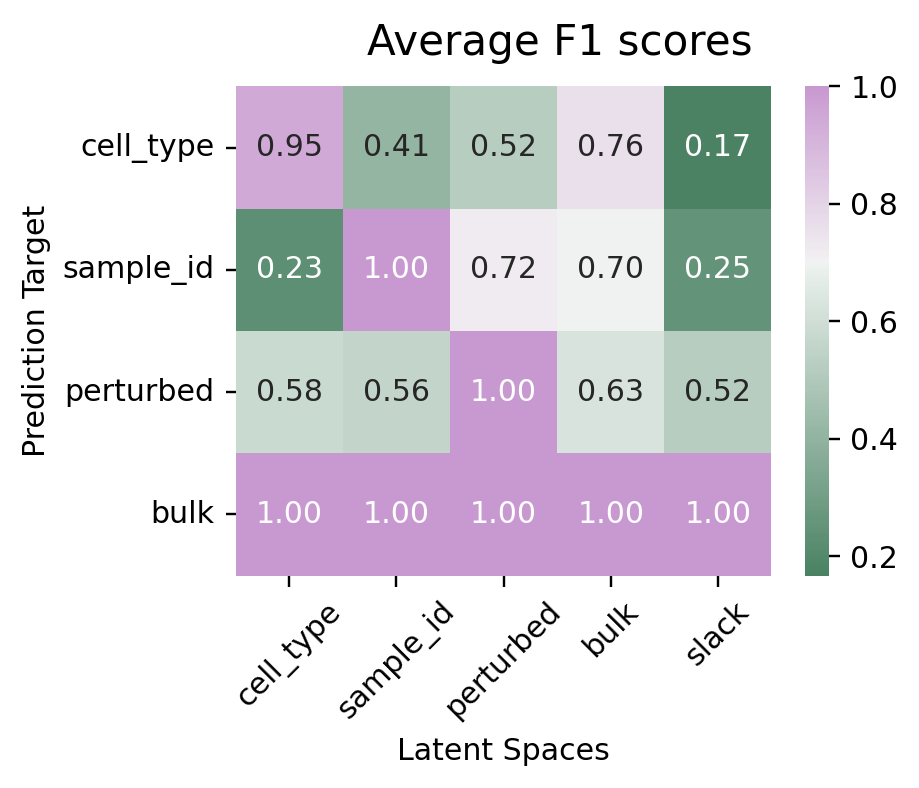

In [ ]:
fig, axs = plt.subplots(1, figsize=(4,3), dpi=216)

sns.heatmap(rf_f1_df, annot=True, fmt=".2f", ax=axs, center=np.mean(np.mean(rf_f1_df)), cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True))
axs.set_xlabel('Latent Spaces')
axs.set_ylabel('Prediction Target')
fig.suptitle("Average F1 scores", fontsize=14)
axs.tick_params(axis='x', rotation=45)


# **Plot deconvolution estimates**


Here, we will plot the estimates of the bulks we used in training that were either labeled (CTRL samples) or unlabeled (STIM samples).

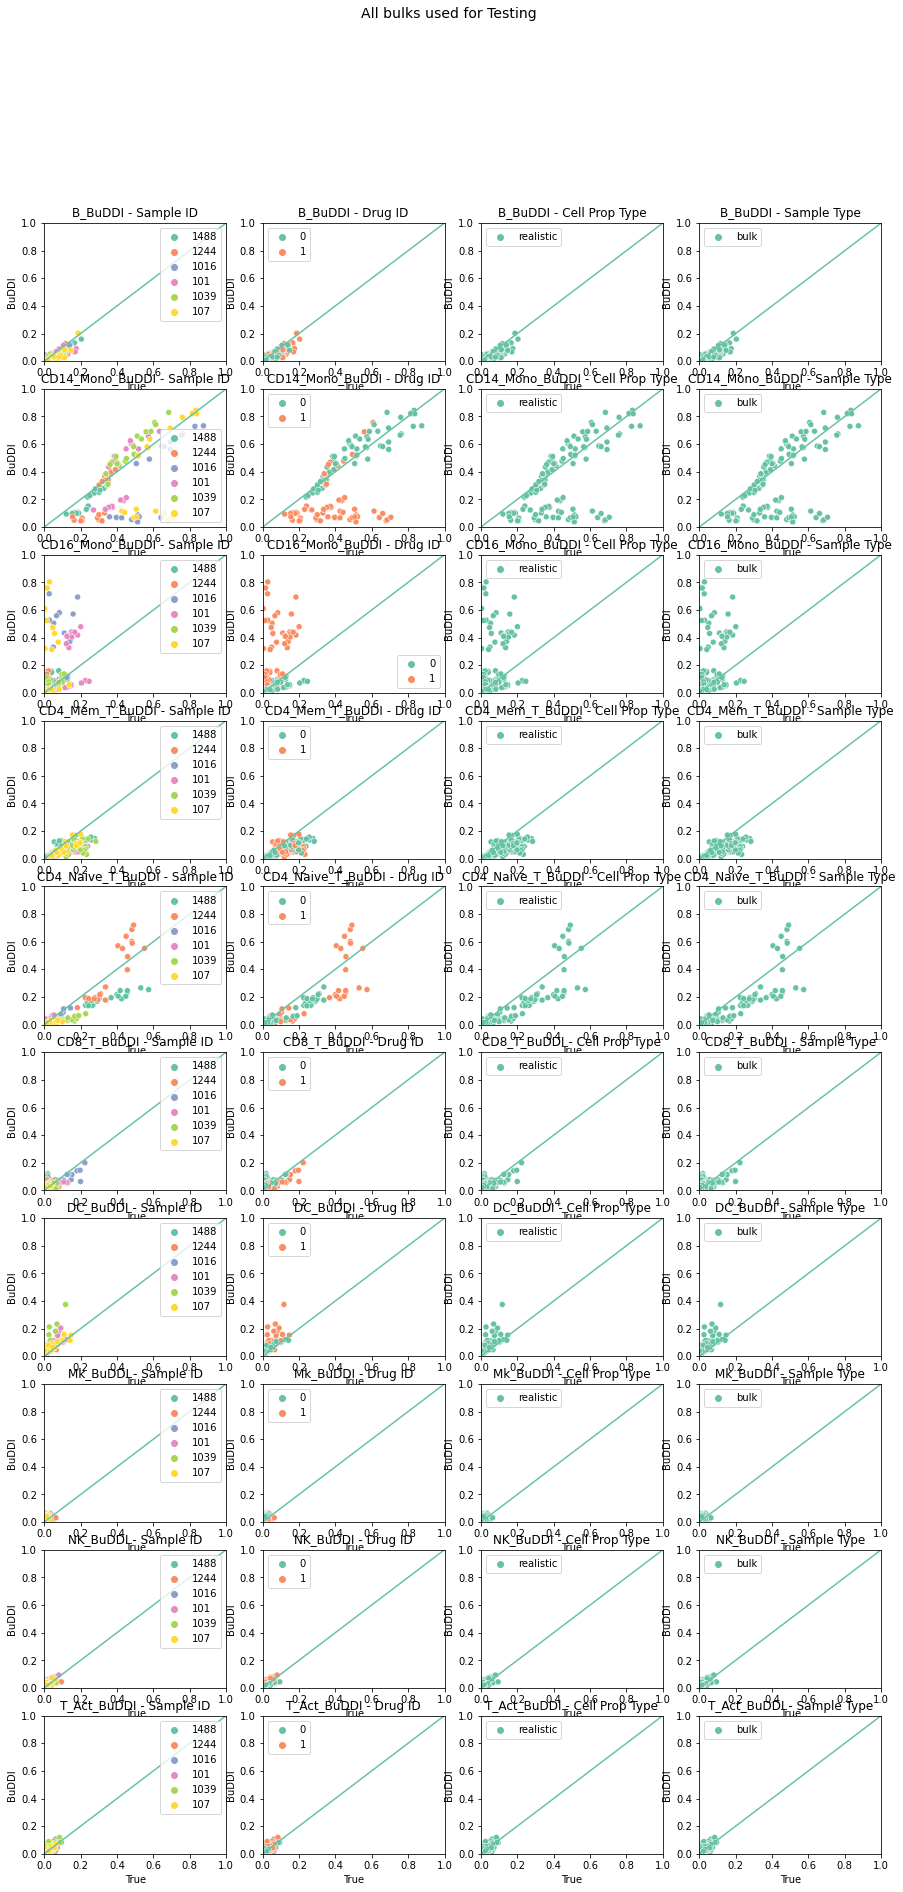

In [ ]:
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Cell Prop Type", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Sample Type", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("All bulks used for Testing", fontsize=14)

fig.show()



In [ ]:
from scipy.stats import spearmanr, pearsonr

# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


### look at BuDDI results alone

MSqE mean: 0.0023812880918056023, median: 0.0021442222768673002, max: 0.005729178351018072
Spearman mean: 0.6391951515151515, median: 0.6606060606060605, max: 0.9030303030303028
Pearson mean: 0.9435472151006051, median: 0.9449382663546652, max: 0.9973777500879574
MSqE mean: 0.0024617158884262134, median: 0.0024919865585323825, max: 0.0060447446015052374
Spearman mean: 0.6954521212121212, median: 0.7212121212121211, max: 0.9878787878787878
Pearson mean: 0.9485213296025642, median: 0.9603276746267113, max: 0.9976211104362628
MSqE mean: 0.002983636271318975, median: 0.00252174870880834, max: 0.013905768081508441
Spearman mean: 0.49691151515151516, median: 0.5030303030303029, max: 0.8787878787878788
Pearson mean: 0.9325925722084796, median: 0.937135843367787, max: 0.9969591850871291
MSqE mean: 0.02161032228200317, median: 0.012989985073705836, max: 0.10123881390810827
Spearman mean: 0.5739393939393939, median: 0.6, max: 0.8303030303030302
Pearson mean: 0.5118655106663135, median: 0.5699436

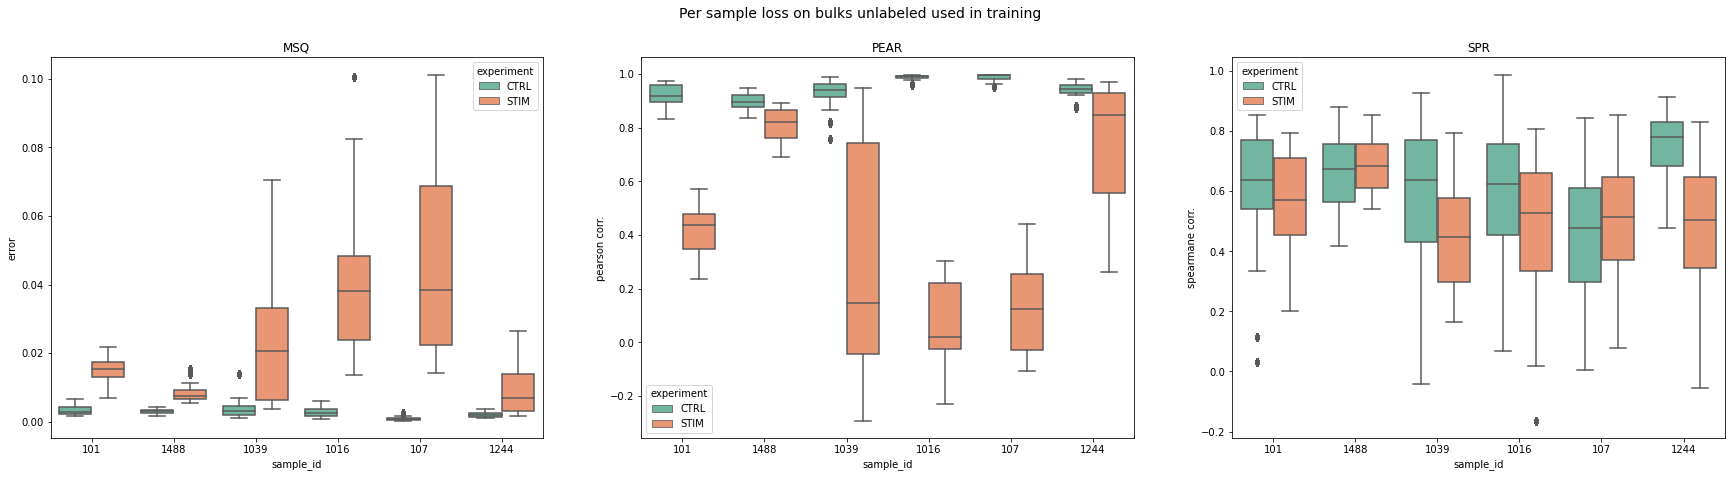

In [ ]:


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.random.choice(idx_tmp, 2500, replace=True)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
# and calculate the error
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)
buddi_err_ctrl1 = get_errors(Y_tmp.to_numpy(), prop_outputs)

prop_outputs = res2_classifier.predict(X_tmp, batch_size=500)
buddi_err_ctrl2 = get_errors(Y_tmp.to_numpy(), prop_outputs)

prop_outputs = res3_classifier.predict(X_tmp, batch_size=500)
buddi_err_ctrl3 = get_errors(Y_tmp.to_numpy(), prop_outputs)

buddi_err_ctrl = pd.concat([buddi_err_ctrl1, buddi_err_ctrl2, buddi_err_ctrl3])

# format the errors
buddi_err_ctrl["experiment"] = ["CTRL"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["method"] = ["BuDDI"]*buddi_err_ctrl.shape[0]
buddi_err_ctrl["sample_id"] = np.tile(samp_ids, 9) ###


# Now compare across samples
idx_tmp = np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "STIM")
idx_tmp = np.where( idx_tmp)[0]
idx_tmp = np.tile(idx_tmp, 100)


X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# make predictions
# and calculate the error
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)
buddi_err_stim1 = get_errors(Y_tmp.to_numpy(), prop_outputs)

prop_outputs = res2_classifier.predict(X_tmp, batch_size=500)
buddi_err_stim2 = get_errors(Y_tmp.to_numpy(), prop_outputs)

prop_outputs = res3_classifier.predict(X_tmp, batch_size=500)
buddi_err_stim3 = get_errors(Y_tmp.to_numpy(), prop_outputs)

buddi_err_stim = pd.concat([buddi_err_stim1, buddi_err_stim2, buddi_err_stim3])

# format the errors
buddi_err_stim["experiment"] = ["STIM"]*buddi_err_stim.shape[0]
buddi_err_stim["method"] = ["BuDDI"]*buddi_err_stim.shape[0]
buddi_err_stim["sample_id"] = np.tile(samp_ids, 9) ###

plot_df = pd.concat([buddi_err_ctrl, buddi_err_stim])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="experiment", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Per sample loss on bulks unlabeled used in training", fontsize=14)

fig.show()

### compare with BayesPrism and CIBERSORTx

In [ ]:

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


MSqE mean: 0.02161032227795145, median: 0.012989985073705836, max: 0.10123881390810827
Spearman mean: 0.5739393939393939, median: 0.6, max: 0.8303030303030302
Pearson mean: 0.5118655106824229, median: 0.5699436319933477, max: 0.9461496467675828
MSqE mean: 0.025975665937420653, median: 0.018979447057044754, max: 0.10056298983814108
Spearman mean: 0.5202020202020202, median: 0.5393939393939393, max: 0.8545454545454544
Pearson mean: 0.33405800715214684, median: 0.32288719271130084, max: 0.8231204372833701
MSqE mean: 0.024579732733430004, median: 0.020040102456089195, max: 0.1002567611406197
Spearman mean: 0.4753535353535353, median: 0.4666666666666666, max: 0.8303030303030302
Pearson mean: 0.38618502809583244, median: 0.3048068817814711, max: 0.9687513896847006
MSqE mean: 0.010198613348189, median: 0.01036111085671619, max: 0.01911244046362364
Spearman mean: 0.5451188002459106, median: 0.567040907087419, max: 0.8566683972885897
Pearson mean: 0.7630763638162504, median: 0.7814444589897522,

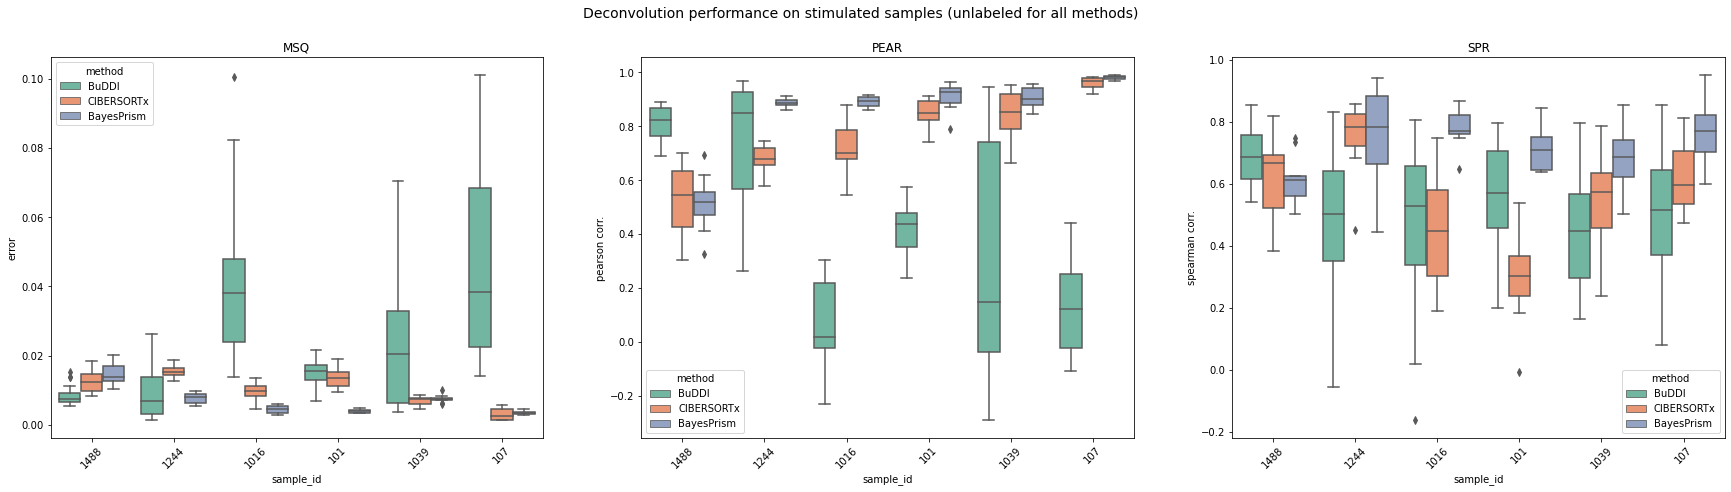

In [ ]:
# Now compare across methods
# we used the following index to do our analysis
# these are training samples -- i.e. used during training 
# BUT they are trained unsupervised i.e. the cell-type proportion for these samples is not known
idx_tmp = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]
idx_keep_size = len(idx_tmp)

# we have to tile in order to match the batch size
idx_tmp_tile = np.tile(idx_tmp, 25)
X_tmp = X_full[idx_tmp_tile,]

# make predictions
prop_outputs1 = res1_classifier.predict(X_tmp, batch_size=500)
prop_outputs2 = res2_classifier.predict(X_tmp, batch_size=500)
prop_outputs3 = res3_classifier.predict(X_tmp, batch_size=500)

# undo the tiling and get propor indicies
prop_outputs1 = prop_outputs1[range(idx_keep_size)]
prop_outputs2 = prop_outputs2[range(idx_keep_size)]
prop_outputs3 = prop_outputs3[range(idx_keep_size)]
X_tmp = X_full[idx_tmp,]
Y_tmp = Y_full.iloc[idx_tmp]
samp_ids = meta_df.sample_id.iloc[idx_tmp]

# read in cibersort
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_full.columns, fill_value=0)


# read in BP
bp_df  = read_bp_result_file(bp_res_path, f"{exp_id}_0", f"{exp_id}_0", num_samp=120)
bp_df = bp_df.reindex(columns=Y_full.columns, fill_value=0)

# get indicies for the stimulated ones
ref_meta_df = meta_df.iloc[idx_tmp]
idx_ref = np.where(ref_meta_df.stim == "STIM")[0]
prop_outputs1 = prop_outputs1[idx_ref]
prop_outputs2 = prop_outputs2[idx_ref]
prop_outputs3 = prop_outputs3[idx_ref]
Y_tmp = Y_tmp.iloc[idx_ref]
samp_ids = samp_ids.iloc[idx_ref]
cibersort_df = cibersort_df.iloc[idx_ref]
bp_df = bp_df.iloc[idx_ref]

# calculate the error
buddi_err1 = get_errors(Y_tmp.to_numpy(), prop_outputs1)
buddi_err2 = get_errors(Y_tmp.to_numpy(), prop_outputs2)
buddi_err3 = get_errors(Y_tmp.to_numpy(), prop_outputs3)
buddi_err = pd.concat([buddi_err1, buddi_err2, buddi_err3])

cibersort_err = get_errors(Y_tmp.to_numpy(), cibersort_df.to_numpy())
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy())

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]
buddi_err["sample_id"] = np.tile(samp_ids, 9) 

cibersort_err["experiment"] = ["true_val"]*cibersort_err.shape[0]
cibersort_err["method"] = ["CIBERSORTx"]*cibersort_err.shape[0]
cibersort_err["sample_id"] = np.tile(samp_ids, 3)

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]
bp_err["sample_id"] = np.tile(samp_ids, 3)

plot_df = pd.concat([buddi_err, cibersort_err, bp_err])

# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")
axs[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
axs[1].tick_params(axis='x', rotation=45)
fig.suptitle("Training on 1, testing on 4", fontsize=14)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearman corr.")
axs[2].tick_params(axis='x', rotation=45)
fig.suptitle("Deconvolution performance on stimulated samples (unlabeled for all methods)", fontsize=14)


fig.show()

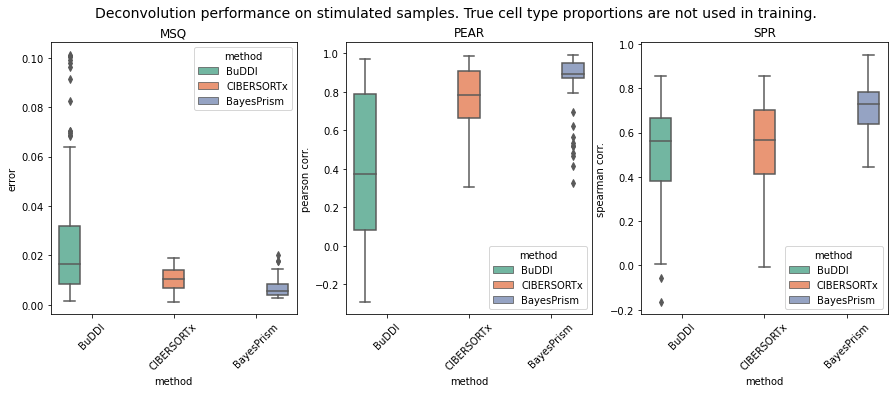

In [ ]:

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")
axs[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
axs[1].tick_params(axis='x', rotation=45)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="method", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearman corr.")
axs[2].tick_params(axis='x', rotation=45)
fig.suptitle("Deconvolution performance on stimulated samples. True cell type proportions are not used in training.", fontsize=14)


fig.show()